In [1]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
from enum import Enum
import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math

# Plotting 
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3

import numpy as np
from numpy.random import PCG64
# import random as rand
from trajectory import * # import the trapezoidal trajectory
import time

# Testing and Debugging
# Example: https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
import unittest             # docs https://docs.python.org/3/library/unittest.html 
import pdb #; pdb.set_trace() # docs https://docs.python.org/3/library/pdb.html

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [2]:
######## RANDOM SEED GENERATOR ########
'''Use only when a new seed is needed'''
# https://numpy.org/devdocs/reference/random/index.html

# from numpy.random import PCG64, SeedSequence

# sq1 = np.random.SeedSequence()

# seed = sq1.entropy

# print(seed)

# ss = SeedSequence(seed)
# print('seed = {}'.format(ss.entropy))
# bg = PCG64(ss)

######### GENERATED SEEDS ##########
## FRUIT TREE CREATOR SEEDS ##
# self.x_fr - 37428395352013185889194479428694397783 
# self.y_fr - 13250124924871709375127216220749555998
# self.z_fr - 165440185943501291848242755689690423219
# self.exist_seed - 264090507119924891834746017829286837587


'Use only when a new seed is needed'

In [3]:
def step(t, dt):
    t = t + dt
    return t

In [4]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]
        
        poly = Poly3DCollection(verts, closed = False, alpha=0.25)
        poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
    def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
        # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        radius = 0.2 # set arbitrarily 
        
        x     = np.linspace(arm_start, arm_end, 3)
        theta = np.linspace(0, 2*np.pi, 3)
        
        theta_grid, x_grid = np.meshgrid(theta, x)
        
        y_grid = radius*np.cos(theta_grid) + center_y
        z_grid = radius*np.sin(theta_grid) + center_z
        
        return x_grid,y_grid,z_grid
            

In [5]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [6]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.time   = []        # time when fruit was picked
        
        # list of fruits passed by the vehicle
        self.passed_fruit = []
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the up-down edges of the camera once
        self.view_bot = self.row_mid - self.height / 2 # up-down edges
        self.view_top = self.row_mid + self.height / 2
        
#         print("top:", self.view_top, "bottom:", self.view_bot)
        
        # side edges of the camera
        self.view_min = 0.
        self.view_max = 0.
        
        
        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        self.view_min = q_curr - self.width / 2 # side edges
        self.view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if self.view_min < 0:
            self.view_min = 0 # will need to change this to a beginning value like below
            
#         j = self.i_lastFruit # the last fruit that was added (so it repeats less)
        
        # find where the picking flag array is stating there are unpicked fruit
        unpicked_indexes = np.where(sortedFruit[3,:] == 0) # should be a 1D array of indexes 
                
        for f_index in unpicked_indexes[0]:
            try:
                if sortedFruit[1,f_index] > self.view_min and sortedFruit[1,f_index] < self.view_max:
                    # now check vertical edges
                    if sortedFruit[2,f_index] > self.view_bot and sortedFruit[2,f_index] < self.view_top:
                        # now check if it has been picked before
                        if sortedFruit[3,f_index] == 0.:
                            # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                            # so it can't really be used either way as a goal
                            key = math.ceil(sortedFruit[1,f_index]*1000) 
                            value = int(f_index) # have to go from int64 (from array) to a base int
                            # add the value to the b-tree
                            self.fruitBTree.update({key:value})

                elif sortedFruit[1,f_index] > self.view_max:
                    # no fruit left to add
                    break
#                 j = j + 1
            except IndexError:
                print("*** Finished going through available fruit ***")
                break
                
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        
        # use bernoulli distribution to 
        self.time.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.time)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [7]:
class scheduler(object):        
        
    def __init__(self, n_goals, num_row, num_arms, v_max, a_max):
        # need to figure out the type of schedule being used 
                      
        #################### CLASS VARIABLES ####################
        self.v_max = v_max
        self.a_max = a_max
        self.d_max = a_max
        
        # robotic system configuration
        self.num_rows     = num_row
        self.num_arms_row = num_arms
        
        total_arms = self.num_rows * self.num_arms_row
        
        # arm mounting frame width, since arms aren't just points in space
        self.mounting_width = 0.2 # should match the cylinder drawn by the draw class 
        
        # variables for the goals
        self.n_goals = n_goals # number of goals the greedy scheduler will find
        # create a matrix of queues that hold the next fruit to pick, one queue per each arm 
        self.goal_queue = np.ndarray((self.num_rows, self.num_arms_row), dtype=object) # create the matrix
        
        for rows in range(self.num_rows):       
            for count in range(self.num_arms_row): 
                self.goal_queue[rows, count] = queue.Queue() # populate the matrix with queue objects
                
        ######################### FLAGS #########################
        # until I can figure out Enum
        
        # Arm cofiguration flags
        self.conf_INDIVIDUAL = 0
        self.conf_SHARED     = 1
        
        ######################## MODULES ########################
  
        
        ################ SELF FUNCTIONS AT INIT #################
        self.trajCalc = Trajectory(self.v_max, self.a_max, self.d_max) # to be able to calculate trajectories              
                    
    def edfScheduler(self, a, row_picture, fruit, v_v, arm_conf):
        '''Earliest deadline first algorithm with batches'''
        # base setting is with arms as individuals
        
        # keyword parameters in functions, https://treyhunner.com/2018/04/keyword-arguments-in-python/
        
        # get arm or for each arm?
        for rows in range(self.num_rows): 
            
            arm_location = np.zeros([self.num_rows, self.num_arms_row])
            back_edge    = np.zeros([self.num_arms_row, 1])
            front_edge   = np.zeros([self.num_arms_row, 1])
            # variable that adds up times to goal to figure out the edges for the next arm 
            time_tot = []
            
            # list of all the goals that will be put into a queue at the end
            pregoals = []
                        
            for i in range (self.num_arms_row):
                # create a matrix with the starting location values for all three arms
                arm_location[i] = np.copy(a[rows,i].q_a)
                # create arrays for the front and back edges of each arm
                back_edge[i]  = np.copy(a[rows,i].y_edges_f[1])
                front_edge[i] = np.copy(a[rows,i].y_edges_f[0])
                # create a new list in time_tot for each new arm
                time_tot.append([0.])
                # make a list of pregoals in the row list, for each arm
                pregoals.append([])
                
            unpick = [] # list to make sure goals don't repeatedly get checked but are unlisted as picked later
            
            # get list of next X number of fruit and add them to a queue
            for pears in range(n_goals):
                for arm_free in range((self.num_arms_row-1), -1, -1): # as long as the arms are moving back to front picking fruits,
#                 for arm_free in range(self.num_arms_row):
                    # we need to figure out the back arm's location first?
                    if len(row_picture[rows].fruitBTree) > 0:                               
                        
                        # get the location of this arm's back edge and convert to integer to get a value to compare keys                  
                        potential_key = math.floor(back_edge[arm_free]*1000)
                    
                        # find a value in the B-tree that fits the first location 
                        try: # if no key exists after the potential key, break out rather than crash the program
                            key = row_picture[rows].fruitBTree.minKey(potential_key) 
                            index = row_picture[rows].fruitBTree[key]

                            # check that the goal/fruit does not pass the front part of the frame if frontmost arm
                            # or if the arm's are in individual work space
                            if arm_free == self.num_arms_row-1 or arm_conf == self.conf_INDIVIDUAL:
                                if fruit.sortedFruit[1,index] > front_edge[arm_free]:
                                    # if it does, stahp
                                    break
                            # choose the first fruit as a goal to be given to the arm
                            goal_new = row_picture[rows].fruitBTree.pop(key)
                            goal_coord = np.copy(fruit.sortedFruit[0:3,goal_new])
                            # calculate the time to the fruit
                            p_time = self.pickTime(arm_location[arm_free,:], goal_coord)

                            # compare with back_edge's location at that point, remove if not possible reach (okay if grabbed before vehicle passes)
                            temp_back_edge = back_edge[arm_free] + v_v[1]*p_time # maybe need to add arm speed?

                            if temp_back_edge < goal_coord[1] and fruit.sortedFruit[3,index] == 0.:  # for now only the y-coordinate
#                                 print("")
#                                 print("arm", arm_free, "in row", rows)
#                                 print("arm location", arm_location[arm_free,1], "goal y-coord",goal_coord[1], "temp back", temp_back_edge)
#                                 print("")

                                # add to list, index is given, not the coordinates
                                pregoals[arm_free].append(goal_new)
                                # calculate retraction and drop-off times
                                r_time = self.returnTime(arm_location[arm_free,:], goal_coord, a[rows,arm_free].z_edges_f[1])
                                # set newest location
                                arm_location[arm_free,1] = goal_coord[1]          # y-coord goal was last moved y location
                                arm_location[arm_free,2] = a[rows,arm_free].z_edges_f[1] # b/c of drop off, that's the new z-coordinate
                                # x location should always end at the starting point x-coord 

                                if arm_conf == self.conf_INDIVIDUAL:
                                    # if the arms work in individual spaces, they are only affected by the vehicles's speed
                                    back_edge[arm_free] = back_edge[arm_free] + v_v[1]*(p_time + r_time)
                                    front_edge[arm_free] = front_edge[arm_free] + v_v[1]*(p_time + r_time)

                                elif arm_conf == self.conf_SHARED:
                                    # if the arms are sharing the row space, their edges are based on the other arm's velocity
                                    time_tot[arm_free].append([arm_location[arm_free,1], p_time + r_time])

                                    if arm_free == self.num_arms_row-1:
                                        # don't care about the front edge
                                        front_edge[arm_free] = front_edge[arm_free] + v_v[1]*(p_time + r_time)
                                        # maybe: (prolly will have to calculate it?)
                                        back_edge[arm_free]  = arm_location[arm_free-1,1]+ v_v[1]*(p_time + r_time)

                                    elif arm_free == 0:
                                        # don't care about the back edge
                                        back_edge[arm_free] = back_edge[arm_free] + v_v[1]*(p_time + r_time)
                                        # maybe: (prolly will have to calculate it?)
                                        front_edge[arm_free] = arm_location[arm_free+1,1] + v_v[1]*(p_time + r_time)

                                    else:
                                        # care about both
                                        front_edge[arm_free] = arm_location[arm_free+1,1] + v_v[1]*(p_time + r_time)
                                        back_edge[arm_free]  = arm_location[arm_free-1,1] + v_v[1]*(p_time + r_time)

                                # set the index's fruit as picked
                                fruit.sortedFruit[3,goal_new] = 1.
                                fruit.sortedFruit[4,goal_new] = arm_free
#                             else:
                            elif fruit.sortedFruit[3,goal_new] == 0:
                                fruit.sortedFruit[3,goal_new] = 1.
                                # however, populate a list of fruit that will go back to being not picked after this
                                unpick.append(goal_new)

                        except ValueError:
                            print("*** No value came up, broke out of the if statement ***")
#                             break
                            pass

                # unpick all the unpickable fruit... not doing very much
                for i in range(len(unpick)):
                    fruit.sortedFruit[3,i] = 0.
#                     print("Clearing some space", i)

            # we can do some post-processing here to make the list of goals better :)
#             print("GOAL LIST")
#             print(pregoals)
            # add the goals to the queue
            for arms_to_go in range(self.num_arms_row):
                for x in pregoals[arms_to_go]:
                    self.goal_queue[rows, arms_to_go].put(x)
                    
        
    def pickTime(self, a_coord, goal):
        '''Calculate move and extend time for an arm to move from curr position to a fruit position'''
        x_time = self.calcTrapTimes(a_coord[0], goal[0], 0.)
        y_time = self.calcTrapTimes(a_coord[1], goal[1], 0.)
        z_time = self.calcTrapTimes(a_coord[2], goal[2], 0.)
        
        time_pick = x_time + max(y_time, z_time)
        
        return(time_pick)
    
    
    def returnTime(self, a_coord, goal, z_bottom):
        '''Calculate total retract and drop off cycle time for a fruit'''
        # maybe add grip time later?
        
        # calculate x, y and z times as the arm moves from curent position to the goal
        x_time = self.calcTrapTimes(goal[0], a_coord[0], 0.) # opposite :)
        z_time = self.calcTrapTimes(goal[2], z_bottom, 0.)
        
        time_ret = x_time + z_time
        
        return(time_ret)
        
        
    def calcTrapTimes(self, q_start, q_end, v_start):
        '''Get the time it takes to move in trapezoidal trajectory'''
        self.trajCalc.adjInit(q_start, v_start)
        self.trajCalc.noJerkProfile(self.trajCalc.q0, q_end, self.trajCalc.v0, self.v_max, self.a_max, self.d_max)
         
        total_time = self.trajCalc.Ta + self.trajCalc.Tv + self.trajCalc.Td
        
        return(total_time)


    def singleFruitScheduler(self, num_row, num_arms, a, row_picture, fruit):
        '''Assigns fruit one at a time to each fruit. Not really a scheduler, but useful for testing'''
        
        # for each row
        for rows in range(num_row):
            # check if there are any arms that are free 
            for arm_free in range(num_arms):
                if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                    # get the location of this arm's back edge and convert to integer to get a value to compare keys                  
                    potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000)
                    # find a value in the B-tree that fits it's location 
                    try: # if no key exists after the potential key, break out rather than crash the program
                        key = row_picture[rows].fruitBTree.minKey(potential_key)
                        index = row_picture[rows].fruitBTree[key]

                        # check that the goal does not pass the front part of the frame
                        if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0] and fruit.sortedFruit[3,index] == 0.:
#                         if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                            # choose the first fruit as a goal to be given to the arm
                            goal_new = row_picture[rows].fruitBTree.pop(key)
                            # set the index's fruit as scheduled to be picked
                            fruit.sortedFruit[3,goal_new] = 1.
                            # give the arm the index so that it can set it back to 0 if it does not reach it
                            a[rows,arm_free].goal_index = goal_new
                            # set the new goal
                            a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step)                     

                    except ValueError:
                        print("*** No value came up, broke out of the if statement ***")
                        break
                        

In [8]:
class arm(object):        
        
    def __init__(self, q, q_v, n, num_arms, frame_width, frame_height, column_width, row_n, max_vel, max_accel, row_conf):
        
        ## next level would be for them to be seperate threads with access to the global clock -Stavros
        
        ######################### FLAGS #########################
        # until I can figure out Enum
        self.pickFLAG        = 0     # checks if the fruit has been picked
        self.goalFLAG        = 0     # checks if there is no goal available
        self.stateFLAG       = 0
        
        # Arm configuration flag values set at initialization
        self.conf_INDIVIDUAL = 0
        self.conf_SHARED     = 1
        
        # Fruit picked flag values
        self.state_IDLE      = 0
        self.state_PICKYZ    = 1
        self.state_PICKX     = 2
        self.state_GRAB      = 3
        self.state_RETRACT   = 4
        self.state_UNLOAD    = 5
        
        # Goal being picked or not (for when there are no goals)
        self.goal_FALSE      = 0
        self.goal_TRUE       = 1
        
        # Fruit picked flag values
        self.fruit_UNPICKED  = 0
        self.fruit_PICKED    = 1
        self.fruit_MISSED    = 2
        self.fruit_NONEXIST  = 3
        
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        self.state         = 0                           # arm's state to log % time used for each activity
        self.row_conf      = row_conf                    # sets if the row space is shared or not
        self.num_arms      = num_arms                    # total number of arms in a row
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        # list of time it took to finish each picking cycle
        self.pick_cycle    = []
        self.pick_cycle_s  = 0.  # when the picking cycle timer started
        
        # which fruits were picked and at what time, might only need times if it's being used to determine 
        # the arm's throughput
        self.time_of_picking = []
        
        # frame size
        self.length_f      = 2.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m -> when shared this includes the shared space
        self.height_f      = frame_height # size of enclosing frame, height in m
        self.width_c       = column_width # width of the columns supporting the arms
        
        if self.row_conf == self.conf_SHARED:
            self.width_f    *= self.num_arms # if it's shared space the width is much larger
        
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q_v[1],q[2]])  # frame's center at row and vehicle's center
        
        if self.row_conf == self.conf_INDIVIDUAL:
            self.q_f[1]    = q[1]  # frame's center moves to be individual, rather than the vehicle's center
        
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.]) # 0 is the starting position, 1 is max extension
        self.y_edges_f     = np.array([0.,0.]) # 0 is forward, 1 is in the back
        self.z_edges_f     = np.array([0.,0.]) # 0 is the top, 1 is the bottom
        
        if self.row_conf == self.conf_SHARED:
            self.y_edge_end = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = max_vel 
        self.a_max         = max_accel  
        self.d_max         = max_accel 
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # setting that determines when a new goal can be given, used by outside functions
        self.goal          = np.array([0.,0.,0.])
        self.reached_goals = 0     # how many goals were successfully reached 
        self.goal_index    = 0     # what index did the goal come from 
        self.goals_given   = 0     # how many goals were given to the arm (to check against how many it reached)
        self.numMissed     = 0     # will follow how many times one goal is missed and cancels that goal once too many misses have happened

        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.t_grab        = 0.
        
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)   
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        

    ######################## FUNCTIONS ########################
    def armStep(self, v_v, a, dt, t):
        '''Funtion detailing and following the decision tree for each arm based on the arm state.
        
           INPUTS: vehicle velocity, arm object, global time step, and the global time
           
           OUTPUTS: returns the new location calculated for the arm as a list with three items.'''
 
        q_curr     = np.array([self.q_a[0],self.q_a[1],self.q_a[2]]) # actually q_{t-1}
        goal_r     = np.array([0,0,0]) # has the goal been rached at each axis
        
        epsilon    = 0.001             # allowable error when reaching fruit
        t2Grab     = 2.               # amount of time it takes to grab a fruit during GRABBING
        can_miss   = 2                 # number of allowed misses before looking for new goal
        
        goal_time  = t - self.t        # time since the y-z self timer was started
        
        # move frame to match vehicle's location
        self.moveFrame(v_v, a, dt)     
        
        # defaul to move with vehicle, velocities will be changed depending on state 
        self.v_a[0] = 0.
        self.v_a[1] = 0.
        self.v_a[2] = 0.
        
        if self.goalFLAG == self.goal_FALSE:
            # When the arm is waiting for a new goal
            self.stateFLAG   = self.state_IDLE 
            
        elif self.goalFLAG == self.goal_TRUE:
            # when the arm has a goal             
            # check if fruit can still be reached according to frame's location 
            can_reach = self.reachable()
            
            if (not can_reach) and (self.stateFLAG == self.state_PICKX or self.stateFLAG == self.state_GRAB):
                # need to retract back to the start position before resetting
                self.stateFLAG = self.state_RETRACT
                self.retract(t)
                goal_time = 0.  
                
            if (not can_reach) and self.stateFLAG == self.state_PICKYZ:
                self.resetFlags()
                # remove the picking flag from the fruit scheduler so it can be scheduled again later
                fruit.sortedFruit[3,self.goal_index] = 0.
    
            # start going through the states
            if self.stateFLAG == self.state_PICKYZ:
                # when moving to in the y, z-coordinates and the goal can be reached 
                goal_r[1] = self.calcYVel(goal_time, v_v)
                goal_r[2] = self.calcZVel(goal_time)      # not affected by the vehicle's velocity
                              
                if goal_r[1] == 1 and goal_r[2] == 1: 
                    # check if the arm's location is at the goal +/- epsilon
                    check = self.accCheckYZ()
                    
                    if check == 2:
                        # if both y and z goal locations successfully reached, start moving in the x-dir to grab the fruit
                        self.t    = t           # start time for the new timer for x
                        goal_time = 0.          # restart the timer for x 
                        # move to the next state
                        self.stateFLAG = self.state_PICKX
                        
                    elif check < 2 and self.numMissed < can_miss:
                        # at least one coordinate was not successful
                        self.stateFLAG  = self.state_PICKYZ
                        self.numMissed += 1
                        # recalculate movement to the fruit
                        self.startTrap(t)
                        
                    elif check < 2 and self.numMissed > can_miss:
                        # too many missed attempts, reset flags and find new goal                        
                        self.resetFlags()
                        # remove the picking flag from the fruit scheduler so it can be scheduled again later
                        fruit.sortedFruit[3,self.goal_index] = 0.
                        
                self.calcLocation(q_curr, v_v, dt)
                
            elif self.stateFLAG == self.state_PICKX:
                # when extending out to the fruit in the x-coordinates and the goal can be reached
                goal_r[0] = self.calcXVel(goal_time, v_v)
                # the velocity for the y and z coordinates should be stationary with respect to the world frame
                self.v_a[1] = -v_v[1]
                
                if goal_r[0] == 1:
                    # once again check that the arm is within the goal's location +/- epsilon 
                    check = self.accCheckXYZ()
                    
                    if check == 3:
                        # if all 3 goal coordinates successfully reached move to grabbing the fruit
                        self.stateFLAG = self.state_GRAB
                        self.t_grab = 0.         # amount of time spent grabbing fruit, increases each step in GRAB state
                        
                    elif check < 3 and self.numMissed < can_miss:
                        self.pickFLAG   = self.fruit_MISSED
                        self.stateFLAG  = self.state_RETRACT
                        self.numMissed += 1
                        # will need to retract to recalculate positioning
                        self.retract(t)
                        goal_time       = 0.
                        
                    elif check < 3 and self.numMissed > can_miss:
                        # too many missed attempts, reset flags and find new goal                        
                        self.resetFlags()
                        # remove the picking flag from the fruit scheduler so it can be scheduled again later
                        fruit.sortedFruit[3,self.goal_index] = 0.
                        
                self.calcLocation(q_curr, v_v, dt)
                        
                        
            elif self.stateFLAG == self.state_GRAB:# and can_reach:
                # take some amount of time as machine "picks" the fruit
                self.t_grab += dt
                
                # arm should be stationary at the fruit for the grab amount of time
                self.v_a[0] = -v_v[0]
                self.v_a[1] = -v_v[1]
                
                if self.t_grab >= t2Grab:
                    # need to check that the arm is in the correct location
                    check = self.accCheckXYZ()
                    
                    if check == 3:
                        # successful harvest and the fruit has been grabbed
                        self.pickFLAG  = self.fruit_PICKED
                        self.stateFLAG = self.state_RETRACT
                        # init retracting variables 
                        self.retract(t)
                        # reset timer start for x
                        goal_time = 0.
                        # add to reached goals and remove fruit from schedulable set
                        self.reached_goals += 1
                        fruit.sortedFruit[3,self.goal_index] = 2. # set environment fruit as picked
                        # "pick" the fruit and remove it from the vision system's b-tree 
                        row_picture[self.row_n].fruitPicked(self.q_a, t)
                        # save the time of picking
                        self.time_of_picking.append(float(t))
                        
                    elif check < 3 and self.numMissed < can_miss:
                        self.pickFLAG   = self.fruit_MISSED
                        self.stateFLAG  = self.state_RETRACT
                        self.numMissed += 1
                        # will need to retract to recalculate positioning
                        self.retract(t)
                        goal_time       = 0.
                        
                    elif check < 3 and self.numMissed > can_miss:
                        # too many missed attempts, reset flags and find new goal                        
                        self.resetFlags()
                        # remove the picking flag from the fruit scheduler so it can be scheduled again later
                        fruit.sortedFruit[3,self.goal_index] = 0.
                    
                self.calcLocation(q_curr, v_v, dt)
                    
                    
            elif self.stateFLAG == self.state_RETRACT:
                # state where the arm moves back until it reaches the starting x-coordinate, functions to reset 
                # the x-coordinate when fruit is picked or the fruit becomes unreachable
                retracted = self.calcXVel(goal_time, v_v)
                # the velocity for the y and z coordinates should be stable
                self.v_a[1] = -v_v[1]   # NOTE: this might be problematic because it takes up more vehicle "space"
                
                if retracted and self.pickFLAG == self.fruit_PICKED:
                    # unloading will only happen if the fruit was successfully picked
                    self.stateFLAG = self.state_UNLOAD
                    # init unloading variables
                    self.unload(t)
                    goal_time = 0.
                    
                elif retracted and self.pickFLAG == self.fruit_MISSED and self.numMissed < can_miss:
                    # If the fruit has been missed, recaulculate the trap times to get to the correct location
                    self.startTrap(t)
                    # now that it's back to the "start" and times have been recalculated, go back to picking in y and z
                    self.pickFLAG   = self.fruit_UNPICKED
                    self.stateFLAG  = self.state_PICKYZ                
                    
                elif retracted and ((not can_reach) or (self.pickFLAG == self.fruit_MISSED and self.numMissed > can_miss)):
                    # If the fruit cannot be reached, reset all the flags to get a new goal
                    self.resetFlags()
                    # remove the picking flag from the fruit scheduler so it can be scheduled again later
                    fruit.sortedFruit[3,self.goal_index] = 0.
                
                self.calcLocation(q_curr, v_v, dt)
                
            elif self.stateFLAG == self.state_UNLOAD:
                # state where the arm down to the bottom of the frame to "unload" the fruit
                # happens when the fruit was successfully obtained
                unloaded = self.calcZVel(goal_time)
                
                self.calcLocation(q_curr, v_v, dt)
                
                if unloaded:
                    self.resetFlags()   
                    # save how long it took to finish this picking cycle 
                    pick_cycle_e = t - self.pick_cycle_s
                    self.pick_cycle.append(pick_cycle_e)
#                     if self.n == 0 and self.row_n == 0:
#                         print("")
#                         print("PICK CYCLE END")
#                         print("Goal Index:", self.goal_index)
#                         print("Has the fruit been picked?", fruit.sortedFruit[3,self.goal_index])
#                         print("")
                
            else:
                # maybe an error?
                print("*** Is it just idle? ***")
                print("*** BAD FLAG:", self.stateFLAG, " ***")
                
                # keep in place?
                self.v_a[0] = -v_v[0] 
                self.v_a[1] = -v_v[1]
                
                self.calcLocation(q_curr, v_v, dt)
                      
#         if self.n == 0 and self.row_n == 0:
#             print("")
#             print("Row:", self.row_n, "Arm:", self.n)
#             print("Edges, X:", self.x_edges_f, "Y:", self.y_edges_f, "Z:", self.z_edges_f)
#             print("Goal: {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#             print("Current location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#             print("")
#             print("Is the arm free?", self.free)
#             print("Has the fruit been picked?", fruit.sortedFruit[3,self.goal_index])
#             print("Goals reached:", goal_r)
#             print("Arm state:", self.stateFLAG)
#             print("Where 0:IDLE, 1:PICKYZ, 2:PICKX, 3:GRAB, 4:RETRACT, 5:UNLOAD")
#             print("can it reach?", can_reach)
#             print("")
                
        return self.q_a
                
                
    def calcLocation(self, q_curr, v_v, dt):
        '''Function that calculates the arm location based on the calculated arm velocity, vehicle velocity, 
           and q_{t-1} for each of the tree axis.
           
           INPUTS: q_curr which is q_{t-1}, the vehicle velocity and the global time step size.'''
        # calculate the new location based on calculated velocities
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # fix any edge constraints of the arms trying to go past their frame/other arms
        self.edgeConstraintCheck()
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
        
    def pickData(self):
        '''Function to compile data of when fruit are picked. Still unfinished. Used in plotting.
           Only compiling time data at the moment.'''
#         x_fr = np.array(self.x)
#         y_fr = np.array(self.y)
#         z_fr = np.array(self.z)
        time_pick = np.array(self.time_of_picking)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
#         inv_fruit = np.stack([x_fr, y_fr, z_fr, t])

        return time_pick  # until I know that the coordinates are needed, just use this
        
        
    def resetFlags(self):
        '''Resets all the flags so as to restart the process of getting a goal.'''
        # end of the picking cycle, reset the state, goal, and fruit flags
        self.stateFLAG  = self.state_IDLE
        self.goalFLAG   = self.goal_FALSE
        self.pickFLAG   = self.fruit_UNPICKED
        # set arm as free so that the scheduler can see it
        self.free       = 1
        
        
    def unload(self, t):
        '''Calculates the trajectory for the arm from curr position to bottom of frame (conveyor location).
           should only run if fruit has been obtained and the arm has retracted'''
        self.z.adjInit(self.q_a[2], self.v_a[2])
        self.z.noJerkProfile(self.q_a[2], self.z_edges_f[1], self.z.v0, self.v_max, self.a_max, self.d_max)
        # restart the timer
        self.t  = t      
        
        
    def calcZVel(self, goal_time):
        '''Calculates the arm velocity in the z-coordinate based on the trapezoidal times calculated beforhand.
           Goes through three stages, accel, constant v, deaccel and then a stopped version.
           
           INPUTS: count up "global" timer to determine when to switch from each section and the velocity of the vehicle
           as inputs.
           
           OUTPUTS: 0 as it runs, 1 when the total time has passed to show it finished'''
        out = 0
        
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            out = 1
                
        return out
                
        
    def calcYVel(self, goal_time, v_v):
        '''Calculates the arm velocity in the y-coordinate based on the trapezoidal times calculated beforhand.
           Goes through three stages, accel, constant v, deaccel and then a stopped version.
           
           INPUTS: count up "global" timer to determine when to switch from each section and the velocity of the vehicle
           as inputs.
           
           OUTPUTS: 0 as it runs, 1 when the total time has passed to show it finished'''
        out = 0
        
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            out = 1
                      
        return out
                
    
    def calcXVel(self, goal_time_x, v_v):
        '''Calculates the arm velocity in the x-coordinate based on the trapezoidal times calculated beforhand.
           Goes through three stages, accel, constant v, deaccel and then a stopped version.
           
           INPUTS: count up "global" timer to determine when to switch from each section and the velocity of the vehicle
           as inputs.
           
           OUTPUTS: 0 as it runs, 1 when the total time has passed to show it finished'''
        out = 0
        
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            out = 1
                
        return out
                
                       
    def calcXYZTrap(self):
        '''Calculates the trap times for all three coordinates'''
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
        self.y.adjInit(self.q_a[1], 0)
        self.y.noJerkProfile(self.q_a[1], self.q_f[1], self.y.v0, self.v_max, self.a_max, self.d_max)
        
        self.z.adjInit(self.q_a[2], 0)
        self.z.noJerkProfile(self.q_a[2], self.q_f[2], self.z.v0, self.v_max, self.a_max, self.d_max)
                    
                    
    def retract(self, t):
        '''Begins the process of retracting by calculating the required movement times in the x-coordinate
           and resetting the movement timer.'''
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        # restart the timer
        self.t = t  
        
#         if self.q_a[0] < self.q_f[0]-0.001:
#             print(" ")
#             print("RETRACTING")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
#             print(" ")
#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))

                    
    def reachable(self):
        '''Checks if a fruit is still reachable by checking if the fruit has passed the back edge of the fruit
           workspace or is beyond the extension range. Returns a 1 if the fruit remains reachable, 0 if not.
           Also used to reset the value of the fruit if it has not been picked.'''
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            return 1

        else:
            if self.pickFLAG == self.fruit_UNPICKED: # and fruit.sortedFruit[3,self.goal_index] != 2.:
                # if it's not reachable before it reached it's goal, reset the scheduler's state on that fruit: 
                # It's not scheduled anymore. 
                fruit.sortedFruit[3,self.goal_index] = 0.
#                 print("Fruit skipped")
                    
            return 0 
        
        
    def accCheckXYZ(self):
        '''Adds up the number of coordinates where the arm is within the goal location +/- epsilon.
           Returns the number of successes, up to 3'''
        x = self.accuraccyCheck(self.q_a[0],self.goal[0])
        y = self.accuraccyCheck(self.q_a[1],self.goal[1])
        z = self.accuraccyCheck(self.q_a[2],self.goal[2])
        return x + y + z
    
    
    def accCheckYZ(self):
        '''Adds up the number of coordinates, but only for Y, Z, where the arm 
           is within the goal location +/- epsilon. Returns the number of successes, up to 2'''
        y = self.accuraccyCheck(self.q_a[1],self.goal[1])
        z = self.accuraccyCheck(self.q_a[2],self.goal[2])
        return y + z
    
        
    def accuraccyCheck(self, arm, goal):
        '''Checks if the arm's location is located near enough to the given goal to pick the fruit.
           Based on an allowable error set as epsilon. Returns a zero if too far, one if successful.'''
        epsilon = 0.001 # allowable error
        
        if arm > (goal-epsilon) and arm < (goal+epsilon):
            # if successful in reaching the correct coordinates
            return 1
        else:
            return 0
        
    
    def edgeConstraintCheck(self):
        '''Stops the arm from moving beyond its workspace. If a constraint is ignored, the function will
           change the arm location to be within the bounds, causing error in location but avoiding collisions'''
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]: # totally retracted position
            self.q_a[0] = self.q_f[0]
        
        # stop the arm from moving below or above the bottom of the frame (saw it happen)
        if self.q_a[2] < self.z_edges_f[1]: # bottom
            self.q_a[2] = self.z_edges_f[1]
            
        elif self.q_a[2] > self.z_edges_f[0]: # top
            self.q_a[2] = self.z_edges_f[0]
            
        # stop the arm from moving front or back beyond it's y-edges 
        if self.q_a[1] < self.y_edges_f[1]: # back
            self.q_a[1] = self.y_edges_f[1]

        elif self.q_a[1] > self.y_edges_f[0]: # front
            self.q_a[1] = self.y_edges_f[0]
            
            
    def setGoal(self, goal, t):
        '''Function to give arm a new goal. Initializes movement for each axis and calculates the required 
           trapezoidal times to go from a current location to the goal. 
           
           INPUTS: goal coordinates in x, y, and z and the current global time. '''
#         if self.n == 0 and self.row_n == 0:
#             print("")
#             print("GOAL GIVEN")
#             print("Goal Index:", self.goal_index)
#             print("Has the fruit been picked?", fruit.sortedFruit[3,self.goal_index])
#             print("")
            
        self.free     = 0              # global setting that makes arm's busy state visible to other functions
        self.goal     = goal
        self.goalFLAG = self.goal_TRUE
        
        self.startTrap(t)
        # increase goals given counter
        self.goals_given += 1
        # start picking cycle time measurement here
        self.pick_cycle_s = t
        
        
    def startTrap(self, t):
        '''Function which initializes and performs the trapezoidal time calculations.
        
           INPUTS: global time'''
        # calculate the trapezoidal times for each of the three movement stages (change to S-curve later)
        # init each axis with current location and velocity (will need velocity at some point?)  
        self.x.adjInit(self.q_a[0], 0.) 
        self.y.adjInit(self.q_a[1], 0.) 
        self.z.adjInit(self.q_a[2], 0.)
        
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max) 
        
#         print(" ")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
#         print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
#         print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
#         print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
#         print(" ")

        # reset state as picking in the y and z axis to start the picking cycle
        self.stateFLAG = self.state_PICKYZ
        # maybe start time here? => evaluate how that could change things once in real time
        self.t     = t
     
    
    def moveFrame(self, v_v, a, dt):
        '''Function which calculates the frame location based on the vehicle's speed. Used to 
           set the limits of the frames for each arm.
           
           INPUTS: vehicle speed, the arm object to know the location of all the arms in case 
           the row is in the shared configuration, and the global time step size'''
        # x-values are not affected by the other arms (yet?)
        x_coor       = self.q_f[0]           # center of the x-direction in the frame
        self.q_f[0]  = x_coor + v_v[0]*dt # move the center point as the vehicle moves
        
        retract_edge = self.x_edges_f[0]
        extend_edge  = self.x_edges_f[1]
        
        # move x-dir the edges
        self.x_edges_f[0] = retract_edge + v_v[0]*dt
        self.x_edges_f[1] = extend_edge + v_v[0]*dt
        
        # calculate the changes in y
        if self.row_conf == self.conf_INDIVIDUAL:
            
            y_coor      = self.q_f[1]        # center of the y-direction in the frame
            self.q_f[1] = y_coor + v_v[1]*dt # move the center point as the vehicle moves
            
            # set the value for the edges
            front_edge  = self.y_edges_f[0]
            back_edge   = self.y_edges_f[1]
            
        elif self.row_conf == self.conf_SHARED: 
            # set the value for the edges
            # got a truncated version of *a* that only has the other arms in that row
            
            self.y_edge_end += v_v[1]*dt # move the ends with the vehicle
            
            if self.n == 0:
                # backmost arm doesn't deal with arms behind it
                back_edge   = self.y_edges_f[1]
                front_edge  = a[self.n+1].q_a[1] - self.width_c + a[self.n+1].v_a[1]*dt
            
            elif self.n == self.num_arms-1:
                # frontmost arm doesn't deal with arms in front of it
                back_edge   = a[self.n-1].q_a[1] + self.width_c + a[self.n-1].v_a[1]*dt
                front_edge  = self.y_edges_f[0]
                
            else:
                back_edge   = a[self.n-1].q_a[1] + self.width_c + a[self.n-1].v_a[1]*dt
                front_edge  = a[self.n+1].q_a[1] - self.width_c + a[self.n+1].v_a[1]*dt
            
            # check that it never goes into space at the edges that would be taken up by the other arms
            if front_edge > self.y_edge_end[0]: 
                front_edge = self.y_edge_end[0]
                
            if back_edge < self.y_edge_end[1]:
                back_edge = self.y_edge_end[1]
                
        # move the edges knowing the vehicle and other arms' velocities, the last bit calculate ahead of time
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
        
        
    def initFrame(self):
        '''Calculate the initial location of the edges of the frame based on the vehicle starting position.
           Only runs once during the initialization of the arm object.'''
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
        
        # y-dir edges change according to the row space configuration
        if self.row_conf == self.conf_INDIVIDUAL: # the y-dir edge make up individual rectangles
            # front
            self.y_edges_f[0] = self.q_f[1] + self.width_f / 2 - self.width_c/2
            # back
            self.y_edges_f[1] = self.q_f[1] - self.width_f / 2 - self.width_c/2
            
        if self.row_conf == self.conf_SHARED:
            # the y-dir edge are initialized as the whole row minus some space for the other arms
            # front
            self.y_edges_f[0] = self.q_f[1] + self.width_f / 2 - (self.num_arms - self.n+1)*self.width_c
            # back
            self.y_edges_f[1] = self.q_f[1] - self.width_f / 2 - self.n*self.width_c
            
            self.y_edge_end = np.copy(self.y_edges_f)
                  
        
        

In [9]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))
        arm     = np.full(len(self.x_fruit), np.inf) # will indicate which arm is set to this goal 

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked, arm])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [10]:
class fruitTreeCreator(object):
    def __init__(self, numFruit_row):
        '''Class that can create synthetic distributions to populate a 3D matrix of coordinates for the 
           simulator. Creates the densities for all three rows at one time.

           INPUT: number of fruit for each row

           NEW INPUT: density of fruit, number of sections in the row, row number
           
           OUTPUT: 4D matrix with fruit x, y, z-coordinates, state of the fruit (doesn't exist, picked, 
                   scheduled, etc.)

           CHANGES: will change input to density of fruit instead of number of fruit, will need to be able 
           to have different fruit densities in the row, populate each row independently.'''
        #################### CLASS VARIABLES ####################
        # fruit coordinate lists
        self.x_fr = []
        self.y_fr = []
        self.z_fr = []
        
        # limits for where the fruit can be added
        self.x_lim = [7.,  8.5]
        self.y_lim = [4.5, 20.]
        self.z_lim = [0.,  9.]
        
        # number of fruit created for the row, based on input
        self.numFruit = numFruit_row * 3
        
        # initialize the matrix that will give the fruit information
        self.sortedFruit = np.stack([np.zeros(self.numFruit), np.zeros(self.numFruit), np.zeros(self.numFruit), np.zeros(self.numFruit)])
        
        # rng seeds created through numpy SeedSequence()
        self.x_seed = PCG64(37428395352013185889194479428694397783)
        self.y_seed = PCG64(13250124924871709375127216220749555998)
        self.z_seed = PCG64(165440185943501291848242755689690423219)
        self.exist_seed = PCG64(264090507119924891834746017829286837587) # seeds for binomial distribution which will determine if a fruit exists
 
        
        ###################### ENUMERATIONS ######################
#         class Distribution(Enum):
#             UNIFORM = 0,
#             LINE    = 1,
#             CSV     = 2  # Maybe will be a seperate class?
        
    def fruitLine(self, z):
        '''Function to place fruits in random locations on the x and y coordinates,
           based on the uniform distribution but a specific z-coordinate 
           to test reaction when dealing with a "ribbon" of fruit (easy calculations)'''
        # function which creates a line of synthetic fruit to test scheduling algorithms
        # z is the height at which all the fruit will be set (since it's a line!)
        
        self.x_fr = np.random.default_rng(self.x_seed).uniform(self.x_lim[0], self.x_lim[1], self.numFruit)
        self.y_fr = np.random.default_rng(self.y_seed).uniform(self.y_lim[0], self.y_lim[1], self.numFruit)
        
        for fruit in range(self.numFruit):
            # random x-coord for fruit, based on uniform distribution
#             self.x_fr.append(rand.uniform(self.x_lim[0], self.x_lim[1]))
#             # random y-coord for fruit, based on uniform distribution
#             self.y_fr.append(rand.uniform(self.y_lim[0], self.y_lim[1]))
            # z-coordinate (based on z-coordinates given for each line for each row)
            if fruit % 3 == 0:
                self.z_fr.append(z[0])
                
            elif fruit % 3 == 1:
                self.z_fr.append(z[1])
                
            elif fruit % 3 == 2:
                self.z_fr.append(z[2])
                
        self.fruitTreeOut()
        
        
    def fruitUniform(self):
        '''Function to place fruits in random locations in all three coordiantes 
           based on the uniform distribution to test reaction when there is no variation 
           in distance between fruit'''
        # https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.uniform.html#numpy.random.Generator.uniform
        
        self.x_fr = np.random.default_rng(self.x_seed).uniform(self.x_lim[0], self.x_lim[1], self.numFruit)
        self.y_fr = np.random.default_rng(self.y_seed).uniform(self.y_lim[0], self.y_lim[1], self.numFruit)
        self.z_fr = np.random.default_rng(self.z_seed).uniform(self.z_lim[0], self.z_lim[1], self.numFruit)
                
        self.fruitTreeOut()
        
        
    def fruitNormal(self, var):
        '''Function to place fruits in random locations based on the uniform distribution 
           to test variation in distance between fruit'''
        # https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal
        
        # for now test around the middle of each coordinate
        mu_x = (self.x_lim[1] - self.x_lim[0])/2
        mu_y = (self.y_lim[1] - self.y_lim[0])/2
        mu_z = (self.z_lim[1] - self.z_lim[0])/2
        
        self.x_fr = np.random.default_rng(self.x_seed).normal(mu_x, var[0], self.numFruit)
        self.y_fr = np.random.default_rng(self.y_seed).normal(mu_y, var[1], self.numFruit)
        self.z_fr = np.random.default_rng(self.z_seed).normal(mu_z, var[2], self.numFruit)
                
        self.fruitTreeOut()
        
    
    def fruitTreeOut(self):
        # converts list of fruit into arrays to build a matrix used in simulator 
        picked  = np.zeros(len(self.x_fr))
        arm     = np.full(len(self.x_fr), np.inf) # will indicate which arm is set to this goal

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([self.x_fr, self.y_fr, self.z_fr, picked, arm])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

In [11]:
class fruitTreeCreator2(object):
    def __init__(self, y_lim):
        '''Class that can create synthetic distributions to populate a 3D matrix of coordinates for the 
           simulator. Uses inputted densities to create desired fruit rows/robot arm rows .

           INPUT: list made up of the starting and ending y-coord of fruit row
           
           FINAL OUTPUT: 5D matrix with fruit x, y, z-coordinates, state of the fruit (doesn't exist, 
                         picked, scheduled, etc.), and the arm scheduled to pick the fruit
           '''
        #################### CLASS VARIABLES ####################
        # fruit coordinate lists (for all the rows)
        self.x_fr = []
        self.y_fr = []
        self.z_fr = []
        
        # y-limits for where the fruit can be added (x and z will depend on the robot configuration)
        self.y_lim = y_lim
               
        # rng seeds created through numpy SeedSequence()
        self.x_seed = PCG64(37428395352013185889194479428694397783)
        self.y_seed = PCG64(13250124924871709375127216220749555998)
        self.z_seed = PCG64(165440185943501291848242755689690423219)
        self.exist_seed = PCG64(264090507119924891834746017829286837587) # seeds for binomial distribution which will determine if a fruit exists
 
        
    def fruitLine(self, num_rows, row_fruit_density, x_lim, z):
        '''Function to place fruits in random locations on the x and y coordinates, based on the
           uniform distribution but a specific z-coordinate to test reaction when dealing with a
           "ribbon" of fruit (easy calculations)
           
           INPUT: total number of rows of arms, list of desired fruit densities, length arm x-axis
                  range, z height of line
           
           OUTPUT: three lists with x, y, z-coordinates of the fruit'''
        
        # convert from fruit density to number of fruit
        num_densities = len(row_fruit_density) # number of desired fruit densities in the fruit row
        len_x = x_lim[1] - x_lim[0]            # calculate length of the arm's reach in the row
        len_y = self.y_lim[1] - self.y_lim[0]  # calculate the total length of the fruit row
        
        len_sections = len_y / num_densities   # calculate how long each row section is (equal length for all)
        # y-limit start for the first section (updated in loop)
        y_sec_lim = [self.y_lim[0], self.y_lim[0]+len_sections]
        
        for section_n in range(num_densities-1):
            # num_fruit = density * volume (in this case area since z is a single coordinate)
            numFruit = int(row_fruit_density[section_n] * (len_sections*len_x))
            # add the section's fruit coordinate to the fruit list
            x = np.random.default_rng(self.x_seed).uniform(x_lim[0], x_lim[1], numFruit)
            y = np.random.default_rng(self.y_seed).uniform(y_sec_lim[0], y_sec_lim[1], numFruit)
            z = np.zeros(numFruit)
            self.x_fr = np.concatenate((self.x_fr, x))
            self.y_fr = np.concatenate((self.y_fr, y))
            self.z_fr = np.concatenate((self.z_fr, z))
            # calculate the next sections y-limits
            y_sec_lim = [y_sec_lim[0]+len_sections,y_sec_lim[1]+len_sections]  
        
        
    def fruitUniform(self, num_rows, row_fruit_density, x_lim, z_lim):
        '''
           Function to place fruits in random locations in all three coordiantes based on the uniform
           distribution. Default distribution for statistical tests, even though it is not a realistic
           fruit distribution.
           
           INPUT: total number of rows of arms, list of desired fruit densities, length x, z to get volume 
                  
           
           OUTPUT: three lists with x, y, z-coordinates of the fruit
        '''
        # https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.uniform.html#numpy.random.Generator.uniform
        
        # convert from fruit density to number of fruit
        num_densities = len(row_fruit_density) # number of desired fruit densities in the fruit row
        
        len_x = x_lim[1] - x_lim[0]            # calculate length of the arm's reach in the row
        len_y = self.y_lim[1] - self.y_lim[0]  # calculate the total length of the fruit row
        len_z = z_lim[1] - z_lim[0]            # calculate length of the arm's reach in the row
        
        len_sections = len_y / num_densities   # calculate how long each row section is (equal length for all)
        # y-limit start for the first section (updated in loop)
        y_sec_lim = [self.y_lim[0], self.y_lim[0]+len_sections]
        
        for section_n in range(num_densities):
            # num_fruit = density * volume 
            numFruit = int(row_fruit_density[section_n] * (len_sections*len_x*len_z))
            # add the section's fruit coordinate to the fruit list
            x = np.random.default_rng(self.x_seed).uniform(x_lim[0], x_lim[1], numFruit)
            y = np.random.default_rng(self.y_seed).uniform(y_sec_lim[0], y_sec_lim[1], numFruit)
            z = np.random.default_rng(self.z_seed).uniform(z_lim[0], z_lim[1], numFruit)
            self.x_fr = np.concatenate((self.x_fr, x))
            self.y_fr = np.concatenate((self.y_fr, y))
            self.z_fr = np.concatenate((self.z_fr, z))
            # calculate the next sections y-limits
            y_sec_lim = [y_sec_lim[0]+len_sections,y_sec_lim[1]+len_sections] 

            
    
    def fruitTreeOut(self, percent_fake):
        '''Converts list of fruit into arrays to build a matrix used in simulator of the fruit coordinates.
           Also adds fake fruit based on given additional percentage.
           
           INPUT: percent of fake fruit to add (functionality not added)
        
           OUTPUT: 4D array with the three fruit coordinates and fruit state''' 
        # get total amount of fruits in distribution
        total_fruits = len(self.x_fr)
        percent_fake = 0.0
        
        # number of fake fruits to be added 
        num_fake = total_fruits * percent_fake
        
        picked  = np.zeros(total_fruits)
        arm     = np.full(total_fruits, np.inf) # will indicate which arm is set to this goal

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([self.x_fr, self.y_fr, self.z_fr, picked, arm])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

In [12]:
## Set Flag values
class spaceConf(Enum):
    '''Flag values for if the workspace in each row is individual or shared'''
    INDIVIDUAL = 0
    SHARED     = 1
    
    
class calendar(Enum):
    '''Flag values for the type of scheduler to use, name seems like a bad idea :P'''
    SINGLE_FRUIT = 0
    EDF          = 1 # Earliest Deadline First, batch
    

class treeCreation(Enum):
    '''Flags values for the type of data being used as fruit coordinates'''
    CSV_RAJ  = 0
    SYN_LINE = 1
    UNIFORM  = 2
    

class noiseMaker(Enum):
    '''Flags values for the type of noise'''
    TURN_OFF = 0
    TURN_ON  = 1
    
    
class reality(Enum):
    '''Flag values determining how many fruit are real and how many are fake in the simulation'''
    TURN_OFF  = 0
    PERCENT   = 1

In [13]:
###### Parameter settings, will later become a configuration file ######

# fruit row depth, in ft  -- x-axis
fruit_row_ed   = 0.3 # how far the vehicle will be from the edges of the tree
fruit_row_tk   = 1.3 # how far the arms can reach into the canopy

# fruit row length, in ft -- y-axis
fruit_row_st   = 0.  
fruit_row_end  = 16. 

# fruit row height, in ft -- z-axis
fruit_row_bt   = 0.
fruit_row_tp   = 9. 


# decide on the number of arms and rows
num_arms     = 3           # set number of arms on robot, will determine the length of the robot (for now)
num_row      = 3           # set the number of rows of arms
frame_height = 3.          # set the height of the arm's frame
# frame height will be calculated from tree height and number of rows?

# arm's max velocity and acceleration values apparently in ft/s
max_v = 1.
max_a = 10.

# decide if the arms are in individual or shared spaces
space_config = spaceConf.SHARED

# decide on the type of scheduler
appointment = calendar.EDF

# decide what fruit distribution to use to create fruit coordinates
data_config  = treeCreation.UNIFORM

# decide if fake fruit will be added
existance = reality.TURN_OFF

# decide if noise should be added and the distribution
noise_level = noiseMaker.TURN_OFF



In [14]:
'''Initializes all variables according to chosen settings in Parameter Settings'''

##################### Based on Flags #####################

# initializes required variables based on the distribution creation method
if data_config != treeCreation.CSV_RAJ: 
    q_v = np.array([fruit_row_ed-1.0/2-0.3, fruit_row_st]) 
    v_v = np.array([0.,0.04])  # in ft, constant velocity only in y-axis
    # need a specific number of fruit per row for synthetic data
#     numFruit_row = 200  
    # if using the line distribution, this will set the z height for each line
    fruit_lines = [2., 5., 8.]            # in ft
    # initialize the synthetic fruit distribution creator
    fruit = fruitTreeCreator2([fruit_row_st,fruit_row_end]) 
    # settings for an angle offset if the tree data has the fruit set at a diagonal
    arm_offset = 0.
#     fruit = fruitTreeCreator(numFruit_row) 
    
elif data_config == treeCreation.CSV_RAJ:
    q_v = np.array([4.5,7.]) # fruits are in very specific locations
    # CSV fruit are diagonally placed (fix that later?)
    v_v = np.array([0.01,0.05])  # in ft, constant velocity   => for single fruit got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)
    # use Raj's digitized fruit from real trees
    fruit = csvRead()  
    # settings for an angle offset if the tree data has the fruit set at a diagonal
    arm_offset = 0.75 / (num_row-1)
    

fruit_density = []
fake_percent  = []

for n in range(num_row):
    # set fruit density and percent of fake fruit to add (will have to change later to add sections
    # with different densities)
    fruit_density.append([0.95])  # in fruit/ft^3 (unless using LINE, then it's fruit/ft^2)
    if existance == reality.PERCENT:
        fake_percent.append([0.05])
    else:
        fake_percent.append([0.0])
    
if data_config == treeCreation.SYN_LINE:  
    # create synthetic fruit data in a line to test the robot when fruit are set at one specific height
    for r in range(num_row):
        fruit.fruitLine(num_row, fruit_density[r], [fruit_row_ed,fruit_row_tk], z[r])
#     fruit.fruitLine(fruit_lines)
    fruit.fruitTreeOut(fake_percent)
    
elif data_config == treeCreation.UNIFORM:
    # test the robot when there is variation in distance between fruit
#     fruit.fruitUniform()
    for r in range(num_row):
        fruit.fruitUniform(num_row,fruit_density[r],[fruit_row_ed,fruit_row_tk],[fruit_row_bt,fruit_row_tp])
    fruit.fruitTreeOut(fake_percent)
        
    
    
# configure the arm's space, length added to vehicle per arm in the y-direction
if space_config == spaceConf.INDIVIDUAL:
    frame_width  = 3.                
elif space_config == spaceConf.SHARED:
    frame_width  = 1.9 

In [15]:
####################### init vehicle #######################

# make the arm take up space within the space (slowly added)
column_width = 0.2               # width of column holding the arm in place

# configure the vehicle
width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

# used to plot the vehicle
qv0 = []
qv1 = []

##################### init environment #####################
# end of the row (when the back of vehicle reaches this point it should stop)
end_row = fruit_row_end + width_v
t = []         # 'global' time
t_step = 0.
dt = 0.01      # 'global' time step size
runs = 0

# used to plot basic outlines of the robot for better visualization
dr = drawRobot()

# create empty list which will save arm states for plotting and data processing
arm_states = [] 

######################## init camera #######################
row_picture = []

for rows in range(num_row): # one "camera" object per row on vehicle
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
    
######################### init arms ########################

# array of arm object setup
a = np.ndarray((num_row,num_arms), dtype=object) 

# setup for arm initialization
arm0start_y = q_v[1] - (length_v - frame_width)/2  # arm starting position in the y-dir
q_a_new = np.array([0.,0.,0.])                     # used as a temporary value while calculating arm init positions
            
# initialize the arm objects in a matrix set for each row and for the number of arms in  said row
for rows in range(num_row):       
    for count in range(num_arms):      
        # calculate where each new arm should go
        # if fruit's in a diagonal, get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_v[0] + 0.3 + ((num_row-1)*arm_offset - arm_offset*rows)
        q_a_new[1] = arm0start_y + frame_width*count # places the arms either in their space or far from each other
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # last one this makes sure it matches the "camera" object's z-location         
        
        # initialize the new arm
        x = arm(q_a_new, q_v, count, num_arms, frame_width, frame_height, column_width, rows, max_v, max_a, space_config.value)
        # add the arm to the a-list     
        a[rows,count] = x

# for plotting data
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


###################### init scheduler ######################
goal = np.zeros(3) # does this go here? it's an empty array for the goal values for each arm...

# if appointment == calendar.GREEDY:
n_goals = 20       # number of goals the greedy scheduler will look for

s = scheduler(n_goals, num_row, num_arms, max_v, max_a) 
# make a scheduler function that sets n_goals only if it's synthetic data

In [16]:
### MAIN CODE ###

## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_step = step(t_step, dt)
    t.append(float(t_step))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise_level == noiseMaker.TURN_ON):
        # add some noissse! (to the fruit locations)
        noise_level = noiseMaker.TURN_OFF # but not right now
        
    # scheduler setting
    if appointment == calendar.SINGLE_FRUIT:
        s.singleFruitScheduler(num_row, num_arms, a, row_picture, fruit)
        
    elif appointment == calendar.EDF:
        if runs % 100 == 0: # don't want to run the scheduler every millisecond
            s.edfScheduler(a, row_picture, fruit, v_v, space_config.value) 
        # go through the list and give each arm a goal
        for rows in range(num_row):
            # give each free arm in that row a goal
    #         for arm_free in range((num_arms), -1, -1):
                for arm_free in range(num_arms):
                    if a[rows,arm_free].free == 1:
                        # need to check if there are goals
                        if (not s.goal_queue[rows, arm_free].empty()):
                            goal_new = s.goal_queue[rows, arm_free].get()
                            # give the arm the index so that it can set it back to 0 if it does not reach it
                            a[rows,arm_free].goal_index = goal_new
                            # set the new goal
                            a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step) 

    
    # have each arm take a step
    for rows in range(num_row):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, a[rows,:], dt, t_step)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
    
    arm_index = 0
    arm_list  = []
    
    # compile at which state each arm ends the loop to add to plot later
    for rows in range(num_row):
        for arm2state in range(num_arms):
            arm_list.append([arm_index, a[rows, arm2state].stateFLAG])
            arm_index += 1
    
    # save arm states 
    arm_states.append(arm_list)
               
    runs+=1


prog_time = time.time() - start_time

start, end, start velocity: -0.2 1.0705508498659766 0.0
start, end, start velocity: 1.9000000000000001 0.045179215343900125 0.0
start, end, start velocity: 1.5 1.448549770617991 0.0
start, end, start velocity: 1.0705508498659766 -0.2 0.0
start, end, start velocity: 1.448549770617991 0.0 0.0
start, end, start velocity: -0.2 0.7134600028870357 0.0
start, end, start velocity: 2.220446049250313e-16 0.05982431169505631 0.0
start, end, start velocity: 1.5 0.09331199847688876 0.0
start, end, start velocity: 0.7134600028870357 -0.2 0.0
start, end, start velocity: 0.09331199847688876 0.0 0.0
start, end, start velocity: -0.2 0.5149576413414478 0.0
start, end, start velocity: -1.8999999999999997 0.072837677305845 0.0
start, end, start velocity: 1.5 0.6268507936897938 0.0
start, end, start velocity: 0.5149576413414478 -0.2 0.0
start, end, start velocity: 0.6268507936897938 0.0 0.0
start, end, start velocity: -0.2 1.2386629644603953 0.0
start, end, start velocity: 0.045179215343900125 0.28495013014

start, end, start velocity: -0.2 0.33254442725355443 0.0
start, end, start velocity: 0.2738376773058452 0.15104958966667148 0.0
start, end, start velocity: 0.09331199847688909 1.2243259252513838 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.5522786911478172 0.0
start, end, start velocity: 0.2738376773058452 0.9358672952482312 0.0
start, end, start velocity: 0.09331199847688909 1.0089489509128589 0.0
start, end, start velocity: -0.2 1.2489515973459109 0.0
start, end, start velocity: 0.4720861027848788 0.4493759744380572 0.0
start, end, start velocity: 3.5287049370222685 3.738885877472655 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6147259496272528 0.0
start, end, start velocity: 0.4720861027848788 1.246949653238401 0.0
start, end, start velocity: 3.5287049370222685 4.117431218108684 0.0
start, end, start velocity: -0.2 0.32371733455506796 0.0
start, end, start velocity: 0.26549378088662706 0.1068651133892473

start, end, start velocity: 0.5260957721046601 0.7241779696928656 0.0
start, end, start velocity: 1.3382647409365553 2.9338216047142467 0.0
start, end, start velocity: 6.2789994858618225 8.399627584573444 0.0
start, end, start velocity: 0.7241779696928656 0.5260957721046601 0.0
start, end, start velocity: 8.399627584573444 6.0 0.0
start, end, start velocity: 0.7067181501613399 0.8900481726853899 0.0
start, end, start velocity: 0.9738853334477608 0.5605373287129698 0.0
start, end, start velocity: 7.102528638852762 6.509887021745845 0.0
start, end, start velocity: 0.8900481726853899 0.7067181501613399 0.0
start, end, start velocity: 6.509887021745845 6.0 0.0
start, end, start velocity: -0.04500000000000119 0.7326595220954404 0.0
start, end, start velocity: 0.28480466677495997 0.008467953507613757 0.0
start, end, start velocity: 8.344168791424291 6.749894565036299 0.0
start, end, start velocity: 0.7326595220954404 -0.04500000000000119 0.0
start, end, start velocity: 6.749894565036299 6.0 

start, end, start velocity: 0.6420269559830257 -0.2 0
start, end, start velocity: 0.6785781338182393 -0.2 0
start, end, start velocity: 0.4023199382588855 -0.2 0
start, end, start velocity: 0.5439479680314202 0.0 0.0
start, end, start velocity: -0.19999999999983492 1.0488492403391847 0.0
start, end, start velocity: 1.049932689084478 1.4080168641343747 0.0
start, end, start velocity: 3.000000000000428 5.20534047557657 0.0
start, end, start velocity: 0.8217556943733973 1.2526317151181408 0.0
start, end, start velocity: 2.3701626308244412 3.4710928005500463 0.0
start, end, start velocity: 0.41838620727743453 1.2119149251726815 0.0
start, end, start velocity: 1.2526317151181408 0.8217556943733973 0.0
start, end, start velocity: 1.2119149251726815 0.0 0.0
start, end, start velocity: 0.10357813381823182 0.41373701814478786 0.0
start, end, start velocity: 1.9400715380759908 3.481250763723736 0.0
start, end, start velocity: 2.6162688790281208 0.7874893841223443 0.0
start, end, start velocity: 

start, end, start velocity: -0.2 0.9301467788527811 0.0
start, end, start velocity: 2.155558783564638 2.5990882617672284 0.0
start, end, start velocity: 6.0 8.443039579565038 0.0
start, end, start velocity: 7.696410478679823 6.0 0.0
start, end, start velocity: 0.49546370392350225 -0.2 0
start, end, start velocity: -0.2 0.9705087947550683 0.0
start, end, start velocity: 1.5103144865556886 1.6332847342220642 0.0
start, end, start velocity: 6.0 8.205620481434993 0.0
start, end, start velocity: 1.2968186080848336 -0.2 0
start, end, start velocity: 0.6377903156744081 0.0 0.0
start, end, start velocity: -0.2 0.3579252807446403 0.0
start, end, start velocity: 3.5591784725596023 4.0157735400448935 0.0
start, end, start velocity: 3.591935863792304 4.6841826793823005 0.0
start, end, start velocity: 0.3579252807446403 -0.2 0.0
start, end, start velocity: 4.6841826793823005 3.0 0.0
start, end, start velocity: 0.4131140954213064 1.0423496841478679 0.0
start, end, start velocity: 3.3581784725596022 

start, end, start velocity: 3.591935863792304 3.0 0.0
start, end, start velocity: 1.3842847389007524 0.0 0.0
start, end, start velocity: 6.519673035968941 6.0 0.0
start, end, start velocity: -0.2 0.509373905459636 0.0
start, end, start velocity: 1.6480940414640708 2.3217952159386748 0.0
start, end, start velocity: 0.0 2.7344930129944576 0.0
start, end, start velocity: 0.7336886529571832 -0.2 0
start, end, start velocity: 5.013198926824058 3.0 0.0
start, end, start velocity: -0.2 0.30086073054970913 0.0
start, end, start velocity: 3.334057344673132 3.473114664937947 0.0
start, end, start velocity: 3.0 5.873625525684936 0.0
start, end, start velocity: -0.2 0.362210085868846 0.0
start, end, start velocity: 3.404157655891568 3.5213692762502014 0.0
start, end, start velocity: 6.0 6.785388545462494 0.0
start, end, start velocity: 0.9061275082304875 0.641202206781317 0.0
start, end, start velocity: 4.020423648511535 4.457649006536139 0.0
start, end, start velocity: 4.394538385029524 4.5306607

start, end, start velocity: 0.4137370181449094 -0.2 0
start, end, start velocity: -0.2 0.9651403660503459 0.0
start, end, start velocity: 3.5982978557062086 3.772711191657388 0.0
start, end, start velocity: 6.0 8.410524392153196 0.0
start, end, start velocity: 0.5093739054597755 -0.2 0
start, end, start velocity: 0.7874893841225 0.0 0.0
start, end, start velocity: 0.30086073054980866 -0.2 0
start, end, start velocity: 2.7344930129949874 0.0 0.0
start, end, start velocity: 5.873625525685448 3.0 0.0
start, end, start velocity: -0.2 0.7198420979322131 0.0
start, end, start velocity: 3.516734045296761 3.5655401761603134 0.0
start, end, start velocity: 0.0 1.9570623191421266 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6328981026867508 0.0
start, end, start velocity: 3.7367340452967572 4.365593431977908 0.0
start, end, start velocity: 2.444999999999981 1.1031535185105725 0.0
start, end, start velocity: 0.4190996151314813 -0.2 0
start, end, start veloc

start, end, start velocity: -0.1999999999995656 0.4495722371582835 0.0
start, end, start velocity: 0.14339782071887067 0.13284823901615006 0.0
start, end, start velocity: 3.0000000000009415 4.588762015993937 0.0
start, end, start velocity: -0.19999999999960133 0.5775718152453659 0.0
start, end, start velocity: 0.1099285121155775 0.00912851211613841 0.0
start, end, start velocity: 6.000000000001288 8.413169369333088 0.0
start, end, start velocity: -0.19999999999969315 0.37529046092029766 0.0
start, end, start velocity: 4.343063303546116 4.511694131316894 0.0
start, end, start velocity: 3.0000000000012985 4.5380139556818335 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999956558 0.7515818292603549 0.0
start, end, start velocity: 4.557063303546124 4.9545307714057305 0.0
start, end, start velocity: 4.55500000000081 5.5059936529607665 0.0
start, end, start velocity: 8.843847931056498 6.0 0.0
start, end, start velocity: 0.5273121631649964 0.98453933

start, end, start velocity: -0.19999999999953996 0.8921039709632239 0.0
start, end, start velocity: 4.342184667273759 4.556442762803421 0.0
start, end, start velocity: 6.000000000001021 7.906650380476093 0.0
start, end, start velocity: -0.19999999999963197 0.865289409334983 0.0
start, end, start velocity: 5.162246570399114 5.266395442443013 0.0
start, end, start velocity: 5.875053048221002e-13 2.8705854516171505 0.0
start, end, start velocity: 0.6923108599255675 -0.2 0
start, end, start velocity: -0.1999999999995707 1.181302542768332 0.0
start, end, start velocity: 4.6998559533303235 4.94848619509078 0.0
start, end, start velocity: 9.70524767322789e-13 2.2310714780973773 0.0
start, end, start velocity: 8.951854046445874 6.0 0.0
start, end, start velocity: 0.8712147211069644 -0.2 0
start, end, start velocity: 3.8024158463371363 3.0 0.0
start, end, start velocity: 0.7578287459295352 -0.2 0
start, end, start velocity: 1.1233571858176443 -0.2 0
start, end, start velocity: -0.19999999999963

start, end, start velocity: -0.19999999999948376 1.1997678175423747 0.0
start, end, start velocity: 4.443354704269768 4.3610559257099055 0.0
start, end, start velocity: 6.000000000001277 6.442283448267143 0.0
start, end, start velocity: 0.34568305574509084 -0.2 0
start, end, start velocity: -0.19999999999924883 0.9812258562944469 0.0
start, end, start velocity: 3.6707150286175825 4.536463500273516 0.0
start, end, start velocity: 8.632703384602036e-13 2.199302354797204 0.0
start, end, start velocity: 7.894433018857269 6.0 0.0
start, end, start velocity: 1.0845994231006293 -0.2 0
start, end, start velocity: -0.19999999999933055 1.2477891983151859 0.0
start, end, start velocity: 3.5640608627854236 0.040636943809490234 0.0
start, end, start velocity: 3.0000000000015703 5.7530461940647335 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999933055 0.7034945713468113 0.0
start, end, start velocity: 3.5640608627854236 0.43110867817383003 0.0
start, end, 

start, end, start velocity: -0.19999999999934587 0.46170013715720176 0.0
start, end, start velocity: 4.816463500273046 5.985572435367624 0.0
start, end, start velocity: 0.18748375071141438 2.1564177723274023 0.0
start, end, start velocity: -0.1999999999996268 0.3831518290169211 0.0
start, end, start velocity: 6.189361997791341 6.295097048487333 0.0
start, end, start velocity: 3.000000000000057 3.8415920223139985 0.0
start, end, start velocity: -0.19999999999939194 1.1121824679734305 0.0
start, end, start velocity: 4.628463500273044 0.8355276926448809 0.0
start, end, start velocity: 1.12706881588015e-12 1.8213215194286783 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999939194 1.2441413091398432 0.0
start, end, start velocity: 4.628463500273044 1.4685172918175429 0.0
start, end, start velocity: 1.12706881588015e-12 2.8164238400952355 0.0
start, end, start velocity: 0.39511878329475353 -0.2 0
start, end, start velocity: 0.21780702320071738 0.0 0

start, end, start velocity: 0.8475116284997697 -0.2 0
start, end, start velocity: 6.178091280576165 6.0 0.0
start, end, start velocity: -0.19999999999939183 0.7823823474300136 0.0
start, end, start velocity: 6.604684788730333 6.83846241885125 0.0
start, end, start velocity: 8.479561454041717e-13 0.39690846144046854 0.0
start, end, start velocity: -0.1999999999997239 1.2707637085610255 0.0
start, end, start velocity: 5.258061753295104 5.831613971931102 0.0
start, end, start velocity: 6.000000000000094 8.976735256918461 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999973406 1.2429445775578638 0.0
start, end, start velocity: 5.602869405699757 5.753823212427436 0.0
start, end, start velocity: 6.083391689534942 6.812093855590499 0.0
start, end, start velocity: 1.2768714859554584 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999973406 0.37175913219705464 0.0
start, end, start velocity: 5.763061753295122

start, end, start velocity: -0.19999999999960133 0.7363662018298016 0.0
start, end, start velocity: 6.423341716881808 6.420169979246797 0.0
start, end, start velocity: 1.0522305954070027e-12 0.8049735157675828 0.0
start, end, start velocity: -0.1999999999993765 1.1461145751826018 0.0
start, end, start velocity: 3.5909896754210706 4.598964306534013 0.0
start, end, start velocity: 4.547116264248807e-13 1.695198243843807 0.0
start, end, start velocity: 5.6708281011198824 3.0 0.0
start, end, start velocity: 1.2432594066990346 -0.2 0
start, end, start velocity: 1.2707637085602694 -0.2 0
start, end, start velocity: 0.5067897832011022 -0.2 0
start, end, start velocity: 0.36173295075543554 -0.2 0
start, end, start velocity: 7.328150059159556 6.0 0.0
start, end, start velocity: 5.482516614989212 3.0 0.0
start, end, start velocity: 8.976735256916877 6.0 0.0
start, end, start velocity: 5.50541063319622 3.0 0.0
start, end, start velocity: -0.19999999999940216 0.8606549549377611 0.0
start, end, sta

start, end, start velocity: 0.9636684686593644 -0.2 0
start, end, start velocity: 6.045843435440868 6.0 0.0
start, end, start velocity: -0.2 0.5188297691246657 0.0
start, end, start velocity: 7.095711916712789 7.433390401970961 0.0
start, end, start velocity: 6.000052542701014 6.167337495068049 0.0
start, end, start velocity: 1.2137931090933765 -0.2 0
start, end, start velocity: 0.7957952603113742 -0.2 0
start, end, start velocity: -0.2 1.261931207987668 0.0
start, end, start velocity: 7.435673093141326 7.697488618360671 0.0
start, end, start velocity: 1.9949999999999515 2.846529570672933 0.0
start, end, start velocity: 1.261931207987668 -0.2 0.0
start, end, start velocity: 2.846529570672933 0.0 0.0
start, end, start velocity: 0.7787909714439194 0.6967264941525664 0.0
start, end, start velocity: 7.014813037478832 7.7291351538174595 0.0
start, end, start velocity: 1.2208861073099777 0.28636757388117773 0.0
start, end, start velocity: 0.6967264941525664 0.7787909714439194 0.0
start, end,

start, end, start velocity: 0.7349999999999505 1.2843476988310414 0.0
start, end, start velocity: 0.3999224280290978 -0.2 0.0
start, end, start velocity: 1.2843476988310414 0.0 0.0
start, end, start velocity: 0.7559288270837284 -0.2 0
start, end, start velocity: 1.288922509187073 -0.2 0
start, end, start velocity: 2.8465295706755005 0.0 0.0
start, end, start velocity: 6.4531249546067 6.0 0.0
start, end, start velocity: -0.2 0.9384614708721304 0.0
start, end, start velocity: 8.046094963212534 8.331695262465175 0.0
start, end, start velocity: 3.0 5.644555361826009 0.0
start, end, start velocity: 0.9384614708721304 -0.2 0.0
start, end, start velocity: 5.644555361826009 3.0 0.0
start, end, start velocity: 0.003922509187122145 1.2458816428380666 0.0
start, end, start velocity: 7.775043867586189 8.481990037772533 0.0
start, end, start velocity: 5.322485247661371 5.175235542874665 0.0
start, end, start velocity: 1.2458816428380666 0.003922509187122145 0.0
start, end, start velocity: 5.1752355

start, end, start velocity: -0.2 1.0906998238191106 0.0
start, end, start velocity: 8.683590037772857 8.661056015345055 0.0
start, end, start velocity: 3.0 4.490480286536744 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: 0.4041733296765979 -0.2 0
start, end, start velocity: -0.2 0.5448340063644954 0.0
start, end, start velocity: 6.21344667474376 6.286793068051617 0.0
start, end, start velocity: 3.0 5.2766258144011156 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999973406 1.1069791697586395 0.0
start, end, start velocity: 6.980073485901193 7.077416109040501 0.0
start, end, start velocity: 8.45658750646884 6.6923797368623745 0.0
start, end, start velocity: 7.370656443911402 6.0 0.0
start, end, start velocity: 0.937553775966543 -0.2 0
start, end, start velocity: 0.7965256532809099 0.433869814538741 0.0
start, end, start velocity: 8.587116895746878 8.845209675248672 0.0
start, end, start velocity: 0.7491067923083602

start, end, start velocity: 1.8062859140144247 0.0 0.0
start, end, start velocity: 3.46494572822267 3.0 0.0
start, end, start velocity: 1.242944577559174 -0.2 0
start, end, start velocity: -0.2 1.2770212632440414 0.0
start, end, start velocity: 5.260446535213268 5.547869405699968 0.0
start, end, start velocity: 6.0 6.083391689534496 0.0
start, end, start velocity: -0.2 1.0906998238191106 0.0
start, end, start velocity: 8.719263475751813 8.661056015345055 0.0
start, end, start velocity: 3.0 4.490480286536744 0.0
start, end, start velocity: 0.5349999999999503 0.9188304514998642 0.0
start, end, start velocity: 9.006442340843954 9.365481031848402 0.0
start, end, start velocity: 4.695577231145066 4.765933348755473 0.0
start, end, start velocity: 0.9188304514998642 0.5349999999999503 0.0
start, end, start velocity: 4.765933348755473 3.0 0.0
start, end, start velocity: -0.2 0.3240507046785373 0.0
start, end, start velocity: 8.66119337349847 9.407853780273042 0.0
start, end, start velocity: 3.

start, end, start velocity: 6.2334655105886325 6.558972865343291 0.0
start, end, start velocity: 6.0 6.302268734616671 0.0
start, end, start velocity: -0.2 1.0086867430015487 0.0
start, end, start velocity: 6.750193167754503 8.319617863075953 0.0
start, end, start velocity: 3.0 5.894990049740963 0.0
start, end, start velocity: -0.2 0.6046825649146761 0.0
start, end, start velocity: 9.484115973644528 9.608984399879422 0.0
start, end, start velocity: 6.0 7.7331090692068845 0.0
start, end, start velocity: 8.281477826317147 6.0 0.0
start, end, start velocity: -0.2 0.5667702656938933 0.0
start, end, start velocity: 9.409253780273765 9.538631851179108 0.0
start, end, start velocity: 3.0 4.839663742317388 0.0
start, end, start velocity: -0.2 1.0772341298872208 0.0
start, end, start velocity: 9.519703060597749 9.776029278883986 0.0
start, end, start velocity: 0.0 2.82201656522979 0.0
start, end, start velocity: -0.2 0.7638797592082829 0.0
start, end, start velocity: 7.501767971449774 7.6786053

start, end, start velocity: -0.2 0.5320653684531309 0.0
start, end, start velocity: 9.8932292788845 9.999626991673928 0.0
start, end, start velocity: 0.0 1.307287215678469 0.0
start, end, start velocity: 6.181710115999598 6.0 0.0
start, end, start velocity: 0.7616977857279849 -0.2 0
start, end, start velocity: -0.2 1.0282131323296435 0.0
start, end, start velocity: 9.999626991674033 10.293363021244431 0.0
start, end, start velocity: 0.19499999999995 1.3962995509927723 0.0
start, end, start velocity: 1.0282131323296435 -0.2 0.0
start, end, start velocity: 1.3962995509927723 0.0 0.0
start, end, start velocity: -0.10234705597458514 0.8637446838433247 0.0
start, end, start velocity: 9.276356949186146 10.383299141870264 0.0
start, end, start velocity: 2.440980188288447 0.11772834441964108 0.0
start, end, start velocity: 0.8637446838433247 -0.10234705597458514 0.0
start, end, start velocity: 0.11772834441964108 0.0 0.0
start, end, start velocity: 0.3999224280296345 1.0249528398886498 0.0
sta

start, end, start velocity: 1.043010437441629 -0.2 0
start, end, start velocity: 0.4193654914899284 -0.2 0
start, end, start velocity: -0.2 1.0293139423337816 0.0
start, end, start velocity: 10.43787649822429 10.934985787730472 0.0
start, end, start velocity: 4.417951094215651 4.368561270531034 0.0
start, end, start velocity: 1.0293139423337816 -0.2 0.0
start, end, start velocity: 4.368561270531034 3.0 0.0
start, end, start velocity: -0.2 0.901593134797319 0.0
start, end, start velocity: 10.23687649822429 10.26851057764026 0.0
start, end, start velocity: 3.031522866901494 4.417951094214397 0.0
start, end, start velocity: 0.901593134797319 -0.2 0.0
start, end, start velocity: 4.417951094214397 3.0 0.0
start, end, start velocity: 0.99801043744167 0.6433478380152877 0.0
start, end, start velocity: 9.408742787959005 11.19400141344062 0.0
start, end, start velocity: 4.795264816860476 4.529463161298046 0.0
start, end, start velocity: 0.6433478380152877 0.99801043744167 0.0
start, end, start 

start, end, start velocity: -0.2 0.9569860505303931 0.0
start, end, start velocity: 10.993785787731117 11.388054710284722 0.0
start, end, start velocity: 3.0 4.8811686548162445 0.0
start, end, start velocity: 0.9569860505303931 -0.2 0.0
start, end, start velocity: 4.8811686548162445 3.0 0.0
start, end, start velocity: -0.2 1.1064844162941507 0.0
start, end, start velocity: 10.23687649822429 11.491984799716548 0.0
start, end, start velocity: 3.031522866901494 3.8791580636203227 0.0
start, end, start velocity: 1.1064844162941507 -0.2 0.0
start, end, start velocity: 3.8791580636203227 3.0 0.0
start, end, start velocity: -0.2 1.2498134348583727 0.0
start, end, start velocity: 9.512940681960211 11.519958499870356 0.0
start, end, start velocity: 3.374999999999943 5.253732198470088 0.0
start, end, start velocity: 1.2498134348583727 -0.2 0.0
start, end, start velocity: 5.253732198470088 3.0 0.0
start, end, start velocity: -0.2 0.7027786121849235 0.0
start, end, start velocity: 11.3880547102847

start, end, start velocity: 6.897840462827713 6.0 0.0
start, end, start velocity: 6.493312246279832 6.0 0.0
start, end, start velocity: -0.2 1.0864580315807821 0.0
start, end, start velocity: 10.165274570972995 10.26562301800918 0.0
start, end, start velocity: 3.0 4.544225391674564 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.901593134797319 0.0
start, end, start velocity: 10.39405796878211 10.26851057764026 0.0
start, end, start velocity: 3.058156114363118 4.417951094214397 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.1064844162941507 0.0
start, end, start velocity: 10.39405796878211 11.491984799716548 0.0
start, end, start velocity: 3.058156114363118 3.8791580636203227 0.0
start, end, start velocity: 2.787374113555624 0.0 0.0
start, end, start velocity: -0.2 1.0098779783649772 0.0
start, end, start velocity: 9.449322378307851 9.615162417631707 0.0
start, end, start velocity: 6.0 7.402861214274337 0.0
star

start, end, start velocity: 0.9448997288547621 0.0 0.0
start, end, start velocity: 6.962104540408648 6.0 0.0
start, end, start velocity: 1.0358866104706164 -0.2 0
start, end, start velocity: -0.2 0.6045232111266763 0.0
start, end, start velocity: 12.23453865754628 12.770111455276595 0.0
start, end, start velocity: 6.0 7.924910612183686 0.0
start, end, start velocity: 0.6045232111266763 -0.2 0.0
start, end, start velocity: 7.924910612183686 6.0 0.0
start, end, start velocity: 0.5808866104706661 0.35603127650440364 0.0
start, end, start velocity: 10.30627587415655 12.7981089050357 0.0
start, end, start velocity: 7.811768957818643 6.894154866141166 0.0
start, end, start velocity: 0.35603127650440364 0.5808866104706661 0.0
start, end, start velocity: 6.894154866141166 6.0 0.0
start, end, start velocity: -0.2 1.0098779783649772 0.0
start, end, start velocity: 9.719654807702279 9.615162417631707 0.0
start, end, start velocity: 6.267104540408711 7.402861214274337 0.0
start, end, start velocit

start, end, start velocity: 0.9136616257884085 0.0 0.0
start, end, start velocity: -0.2 1.2320420627365776 0.0
start, end, start velocity: 10.899400920189013 10.904800920188807 0.0
start, end, start velocity: 8.432085168240862 8.4320851682387 0.0
start, end, start velocity: -0.2 0.9614616613962657 0.0
start, end, start velocity: 13.07427897260506 13.217031988842427 0.0
start, end, start velocity: 0.0 1.7444440323944577 0.0
start, end, start velocity: 0.676412775629948 -0.2 0
start, end, start velocity: 0.3554670255742044 -0.2 0
start, end, start velocity: 1.2498134348596832 -0.2 0
start, end, start velocity: 7.761060894857399 6.0 0.0
start, end, start velocity: 2.944261342313204 0.0 0.0
start, end, start velocity: 1.1392010215518518 -0.2 0
start, end, start velocity: 0.9768014908803989 -0.2 0
start, end, start velocity: 5.253732198472088 3.0 0.0
start, end, start velocity: 4.673574924020661 3.0 0.0
start, end, start velocity: 1.2320420627378788 -0.2 0
start, end, start velocity: 7.0288

start, end, start velocity: 0.39843875009185825 -0.2 0
start, end, start velocity: 0.33202068822494535 0.0 0.0
start, end, start velocity: 4.417951094215651 3.0 0.0
start, end, start velocity: -0.2 0.9996136170064747 0.0
start, end, start velocity: 13.838589040706937 13.823273986463128 0.0
start, end, start velocity: 0.0 0.23986228277214194 0.0
start, end, start velocity: 0.6880725736931302 -0.2 0
start, end, start velocity: -0.2 1.210607302982463 0.0
start, end, start velocity: 13.595496869413271 14.038425278518263 0.0
start, end, start velocity: 6.0 6.297143371038781 0.0
start, end, start velocity: 1.210607302982463 -0.2 0.0
start, end, start velocity: 6.297143371038781 6.0 0.0
start, end, start velocity: 0.9723924758105985 1.086614677227125 0.0
start, end, start velocity: 12.246310340779827 14.123831093993752 0.0
start, end, start velocity: 6.7228792605238255 8.252430295612914 0.0
start, end, start velocity: 1.086614677227125 0.9723924758105985 0.0
start, end, start velocity: 8.2524

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.7997443159419297 0.0
start, end, start velocity: 13.25568826369185 13.318188480238009 0.0
start, end, start velocity: 2.9488050421476957 2.732679236389319 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.8466745902332271 0.0
start, end, start velocity: 13.321316977796519 13.989731445848744 0.0
start, end, start velocity: 2.9338050421477093 1.3947502105181815 0.0
start, end, start velocity: -0.2 0.35422104197324783 0.0
start, end, start velocity: 12.896337119515852 13.771292661886722 0.0
start, end, start velocity: 6.0 7.933542950777711 0.0
start, end, start velocity: 0.5569539215867282 -0.2 0
start, end, start velocity: -0.2 0.8328069377853278 0.0
start, end, start velocity: 13.501173357467325 13.39106908916443 0.0
start, end, start velocity: 3.0 4.80419801430291 0.0
start, end, start velocity: 0.3555846537412397 -0.2 0
start, end, start velocity: -0.2 1.1349891783144417

start, end, start velocity: 6.392562043907693 6.0 0.0
start, end, start velocity: 8.578740057317857 6.0 0.0
start, end, start velocity: -0.2 0.8629064396970587 0.0
start, end, start velocity: 14.75111283429587 14.953538458732082 0.0
start, end, start velocity: 6.0 7.032121059915669 0.0
start, end, start velocity: -0.2 0.4955650542295929 0.0
start, end, start velocity: 14.906112834295843 15.251595748681604 0.0
start, end, start velocity: 6.154999999999948 7.973795575751017 0.0
start, end, start velocity: 0.4955650542295929 -0.2 0.0
start, end, start velocity: 7.973795575751017 6.0 0.0
start, end, start velocity: -0.2 0.3340727046047362 0.0
start, end, start velocity: 14.2002310939942 15.467592756758771 0.0
start, end, start velocity: 6.387430295615005 6.0915474158315135 0.0
start, end, start velocity: 0.3340727046047362 -0.2 0.0
start, end, start velocity: 6.0915474158315135 6.0 0.0
start, end, start velocity: -0.2 0.6554203295371115 0.0
start, end, start velocity: 13.012228064156231 15

start, end, start velocity: 3.0192382294586584 3.0 0.0
start, end, start velocity: -0.2 1.1394932648775753 0.0
start, end, start velocity: 14.390807146911314 14.657486745491335 0.0
start, end, start velocity: 3.000149104571378 5.641544672320576 0.0
start, end, start velocity: 0.24499999999995004 0.3503896663813803 0.0
start, end, start velocity: 15.251595748681869 15.62253957056452 0.0
start, end, start velocity: 7.973795575752769 7.148988838725741 0.0
start, end, start velocity: 0.3503896663813803 0.24499999999995004 0.0
start, end, start velocity: 7.148988838725741 6.0 0.0
start, end, start velocity: 0.5149999999999503 1.0135110256064712 0.0
start, end, start velocity: 14.430262800170222 15.68666638648497 0.0
start, end, start velocity: 8.164916118407945 8.287683216343957 0.0
start, end, start velocity: 1.0135110256064712 0.5149999999999503 0.0
start, end, start velocity: 8.287683216343957 6.0 0.0
start, end, start velocity: -0.12871105284751433 0.8830530543556365 0.0
start, end, sta

start, end, start velocity: -0.2 0.5305945050272936 0.0
start, end, start velocity: 12.245098004269767 12.896805509573898 0.0
start, end, start velocity: 3.0 5.9202587338755315 0.0
start, end, start velocity: 7.211692388107169 6.0 0.0
start, end, start velocity: 2.194289543130397 0.0 0.0
start, end, start velocity: -0.18500000000001365 -0.2 0
start, end, start velocity: -0.19998386676967345 1.143454943172956 0.0
start, end, start velocity: 13.091122507452667 14.331389030357592 0.0
start, end, start velocity: 4.346635996272461 4.708299248679208 0.0
start, end, start velocity: -0.2 0.5055559806456755 0.0
start, end, start velocity: 14.908344825915368 13.241784837336192 0.0
start, end, start velocity: 0.0 2.948805042146477 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.2 1.1233303934083523 0.0
start, end, start velocity: 12.896805509574591 13.025315611108535 0.0
start, end, start velocity: 

In [17]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coordinates and time of picking
    # need to have a list that indexes which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t[-1])
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fr)) # reality check
print("")
print("vehicle speed:", v_v[1], "m/s")
print("max arm velocity:", a[0,0].v_max, "m/s, max arm acceleration:", a[0,0].a_max, "m/s^2")
print("")

avg_pick_cycle = []

print("Rear arms are arm no. 0, bottom row is row no. 0:")

for rows in range(num_row):
    for count in range(num_arms):
        # calculate picking cycle average for each arm
        avg_PC = sum(a[rows,count].pick_cycle)/len(a[rows,count].pick_cycle)
        
        # calculate how many fruit were picked overall
        print("total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals, "with an avg. picking cycle time", avg_PC, "sec")
        total_fruit_picked += a[rows,count].reached_goals
        
        avg_pick_cycle.append(avg_PC)
#         print("Arm's average picking cycle time", avg_PC, "sec")
#         print("")

avg_fruit_picked = t[-1] / total_fruit_picked

print("")
print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked, "and Avg. total picking cycle:", sum(avg_pick_cycle)/len(avg_pick_cycle), "sec")



program took: 17.9694185256958 sec
total internal time: 424.9999999997585
total vehicle distance moved: 17.500000000013735
total number of fruit in CSV file: 408

vehicle speed: 0.04 m/s
max arm velocity: 1.0 m/s, max arm acceleration: 10.0 m/s^2

Rear arms are arm no. 0, bottom row is row no. 0:
total fruit reached for arm 0 in row 0 is 42 with an avg. picking cycle time 8.272380952376428 sec
total fruit reached for arm 1 in row 0 is 35 with an avg. picking cycle time 7.043714285711742 sec
total fruit reached for arm 2 in row 0 is 37 with an avg. picking cycle time 7.2875675675642055 sec
total fruit reached for arm 0 in row 1 is 46 with an avg. picking cycle time 8.060217391300165 sec
total fruit reached for arm 1 in row 1 is 33 with an avg. picking cycle time 7.317272727270382 sec
total fruit reached for arm 2 in row 1 is 36 with an avg. picking cycle time 7.184722222219007 sec
total fruit reached for arm 0 in row 2 is 45 with an avg. picking cycle time 7.7871111111070705 sec
total f

<IPython.core.display.Javascript object>


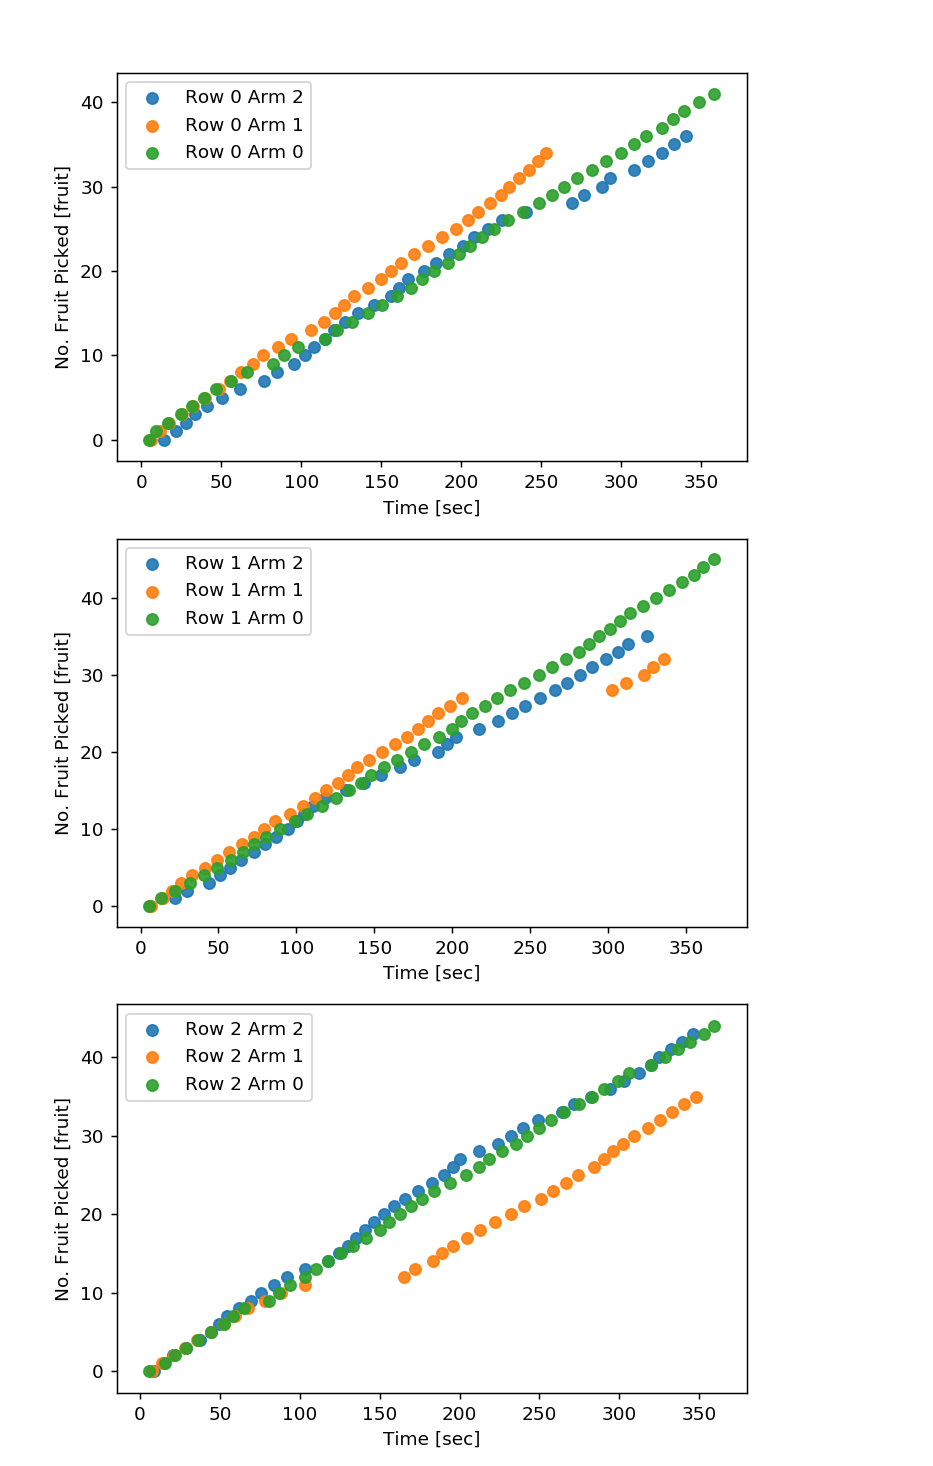

In [18]:
# Plot time versus number of fruit picked per arm
fig, ax = plt.subplots(num_row, figsize=(7, 11))

for rows in range(num_row):
    for manipulators in range((num_arms-1), -1, -1):
        time_apples = np.copy(a[rows,manipulators].pickData())
        apples      = range(np.shape(time_apples)[0])

        
        arm_label = "Row "+str(rows)+" Arm "+str(manipulators)
        
        ax[rows].scatter(time_apples, apples, alpha=0.9, label=arm_label)
        ax[rows].set_xlabel("Time [sec]")
        ax[rows].set_ylabel("No. Fruit Picked [fruit]")
#         ax[rows].set_title("No. of fruit picked versus time")
        ax[rows].legend(loc='upper left', ncol=1)
        
        fig.subplots_adjust(bottom=0.05, top=0.95, right=0.8)
        
        plt.show()
        
        

In [19]:
# analyze the % time each arm is in each state 
idle = 0.
picking = 0.
retracting = 0.
unloading = 0.

tot_num_arms = num_arms*num_row

state_step = 0

state_data = np.zeros((tot_num_arms, len(arm_states)))

for time_step in arm_states:
    for arm_num in time_step:
        state_data[arm_num[0],state_step] = arm_num[1]
        
        if arm_num[1] == 0:
            idle += 1
        elif arm_num[1] == 1:
            picking += 1
        elif arm_num[1] == 2:
            retracting += 1
        elif arm_num[1] == 3:
            unloading += 1
        
    state_step += 1
        
idle_arm = 0.
pick_arm = 0.
retr_arm = 0.
unlo_arm = 0.

row_n = 0
arm_n = 0

# for plotting
idle_plot = []
pick_plot = []
retr_plot = []
unlo_plot = []


# for each arm
for i in range(9):
    for x in state_data[i]:
        if x == 0:
            idle_arm += 1
        elif x == 1:
            pick_arm += 1
        elif x == 2:
            retr_arm += 1
        elif x == 3:
            unlo_arm += 1
    
    total = idle_arm + pick_arm + retr_arm + unlo_arm
    
    idle_plot.append(idle_arm)
    pick_plot.append(pick_arm)
    retr_plot.append(retr_arm)
    unlo_plot.append(unlo_arm)
    
    arm_n += 1
    
    if i%num_row == 0:
        row_n = math.floor(i/num_row)
        arm_n = 0
        
#     print("Arm", arm_n, "in row", row_n)
#     print("Idle:", idle_arm, "[unitless], Picking:", pick_arm, "[unitless], Retracting:", retr_arm, "[unitless], Unloading:", unlo_arm, "[unitless]")
#     print("Idle: {0:.4f}".format(idle_arm/total*100), "[%], Picking: {0:.4f}".format(pick_arm/total*100), "[%], Retracting: {0:.4f}".format(retr_arm/total*100), "[%], Unloading: {0:.4f}".format(unlo_arm/total*100), "[%]")
#     print("")
    
    idle_arm = 0.
    pick_arm = 0.
    retr_arm = 0.
    unlo_arm = 0.



In [20]:
# analyze the % time each arm is in each state 
idle       = 0.
pickingyz  = 0.
pickingx   = 0.
grabbing   = 0.
retracting = 0.
unloading  = 0.

tot_num_arms = num_arms*num_row

state_step = 0

state_data = np.zeros((tot_num_arms, len(arm_states)))

# obtain the state for each arm
for time_step in arm_states:
    for arm_num in time_step:
        state_data[arm_num[0],state_step] = arm_num[1]
        # get totals for each 
#         if arm_num[1] == 0:
#             idle      += 1
#         elif arm_num[1] == 1:
#             pickingyz += 1
#         elif arm_num[1] == 2:
#             pickingx  += 1
#         elif arm_num[1] == 3:
#             grabbing  += 1
#         elif arm_num[1] == 4:
#             retracting += 1
#         elif arm_num[1] == 5:
#             unloading += 1
        
    state_step += 1
        
idle_arm   = 0.
pickyz_arm = 0.
pickx_arm  = 0.
grab_arm   = 0.
retr_arm   = 0.
unlo_arm   = 0.

row_n = 0
arm_n = 0

# for plotting
idle_plot   = []
pickyz_plot = []
pickx_plot  = []
grab_plot   = []
retr_plot   = []
unlo_plot   = []


# for each arm take the state obtained using state_data, determine the state at each time point for each arm 
for i in range(tot_num_arms):
    for x in state_data[i]:
        if x == 0:
            idle_arm   += 1
        elif x == 1:
            pickyz_arm += 1
        elif x == 2:
            pickx_arm  += 1
        elif x == 3:
            grab_arm   += 1
        elif x == 4:
            retr_arm   += 1
        elif x == 5:
            unlo_arm   += 1
    
    # add them all together so that percentages can be calculated
    total = idle_arm + pickyz_arm + pickx_arm + grab_arm + retr_arm + unlo_arm
    
    # get the total amount of time all arms spent in each state
    idle       += idle_arm
    pickingyz  += pickyz_arm
    pickingx   += pickx_arm
    grabbing   += grab_arm
    retracting += retr_arm
    unloading  += unlo_arm
    
    # append the current arm's data to the plotting list
    idle_plot.append(idle_arm)
    pickyz_plot.append(pickyz_arm)
    pickx_plot.append(pickx_arm)
    grab_plot.append(grab_arm)
    retr_plot.append(retr_arm)
    unlo_plot.append(unlo_arm)
    
    arm_n += 1
    
    # used to detemine which row corresponds to the specific arm
    if i%num_row == 0:
        row_n = math.floor(i/num_row)
        arm_n = 0
        
#     print("Arm", arm_n, "in row", row_n)
#     print("Idle:", idle_arm, "[unitless], Picking:", pick_arm, "[unitless], Retracting:", retr_arm, "[unitless], Unloading:", unlo_arm, "[unitless]")
#     print("Idle: {0:.4f}".format(idle_arm/total*100), "[%], Picking: {0:.4f}".format(pick_arm/total*100), "[%], Retracting: {0:.4f}".format(retr_arm/total*100), "[%], Unloading: {0:.4f}".format(unlo_arm/total*100), "[%]")
#     print("")
    
    # reset for the next run
    idle_arm = 0.
    pick_arm = 0.
    retr_arm = 0.
    unlo_arm = 0.



In [21]:
## Functions to add grouping into the arm state percentage plot (and other future plots)
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib

def mk_groups(data):
    # function takes a dictionary (or anything with an items() method, like collections.OrderedDict) and converts it to a data format that is then used to create the chart. It is basically a list
    try:
        newdata = data.items()
    except:
        return

    thisgroup = []
    groups = []
    for key, value in newdata:
        newgroups = mk_groups(value)
        if newgroups is None:
            thisgroup.append((key, value))
        else:
            thisgroup.append((key, len(newgroups[-1])))
            if groups:
                groups = [g + n for n, g in zip(newgroups, groups)]
            else:
                groups = newgroups
    return [thisgroup] + groups

def add_line(ax, xpos, ypos):
    # creates a vertical line in the subplot at the specified positions (in axes coordinates)
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_group_bar(ax, data):
    # takes a dictionary and creates the subplot with the labels beneath
    groups = mk_groups(data)
    xy = groups.pop()
    x, y = zip(*xy)
    ly = len(y)
    xticks = range(1, ly + 2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(x)
    ax.set_xlim(.5, ly + .5)

    scale = 1. / ly
    for pos in range(ly + 1):
        add_line(ax, pos * scale, -.1)
        
    ypos = -.2
    while groups:
        group = groups.pop()
        pos = 0
        for label, rpos in group:
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale, ypos)
        ypos -= .1



<IPython.core.display.Javascript object>


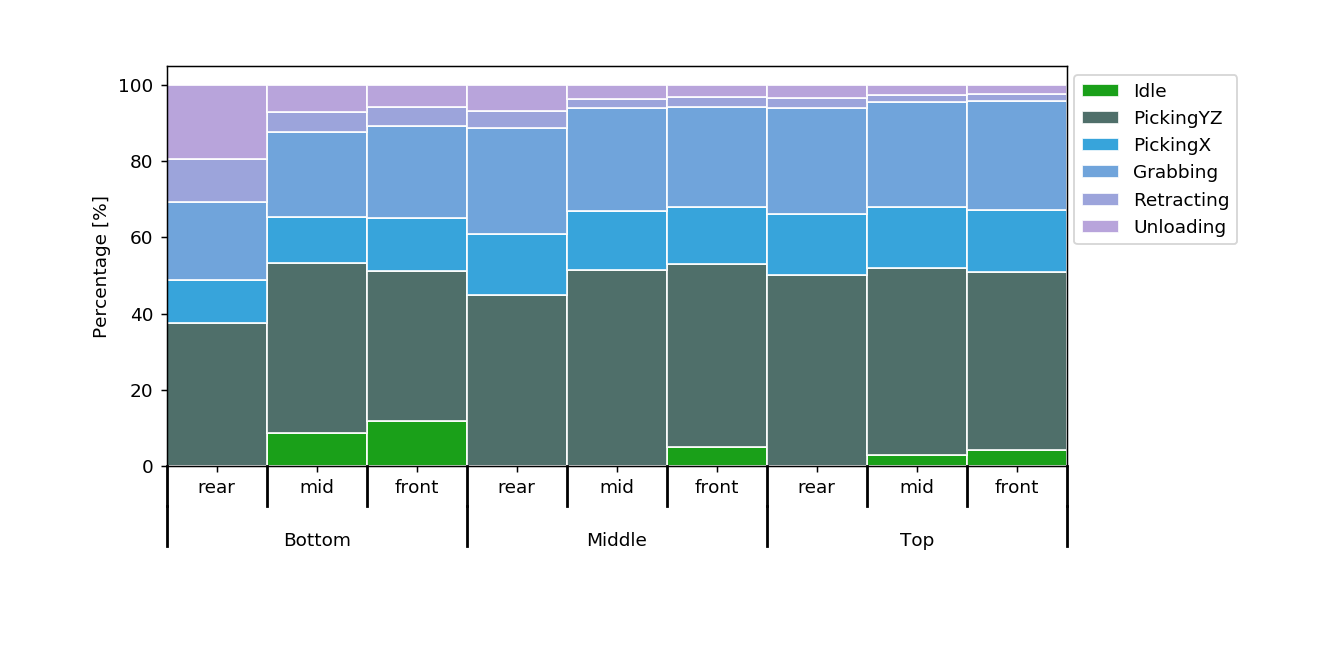

In [22]:
# % stacked bar plot
## https://chrisalbon.com/python/data_visualization/matplotlib_percentage_stacked_bar_plot/

data = {'Bottom':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Middle':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Top':
           {'rear':0,
            'mid':1,
            'front':2
           },
       }



# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(1,len(idle_plot)+1)] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 
# print(tick_pos)

# Create the total steps per state
totals = [i+j+k+l+m+n for i,j,k,l,m,n in zip(idle_plot, pickyz_plot, pickx_plot, grab_plot, retr_plot, unlo_plot)]

# Create the percentage of the total steps for idle state
per_idle = [i / j * 100 for  i,j in zip(idle_plot, totals)]
# Create the percentage of the total steps for pickingyz state
per_pickyz = [i / j * 100 for  i,j in zip(pickyz_plot, totals)]
# Create the percentage of the total steps for pickingx state
per_pickx = [i / j * 100 for  i,j in zip(pickx_plot, totals)]
# Create the percentage of the total steps for grabbing state
per_grab = [i / j * 100 for  i,j in zip(grab_plot, totals)]
# Create the percentage of the total steps for retracting state
per_retr = [i / j * 100 for  i,j in zip(retr_plot, totals)]
# Create the percentage of the total steps for unloading state
per_unlo = [i / j * 100 for  i,j in zip(unlo_plot, totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using idle data
       per_idle, 
       # labeled 
       label='Idle', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#019600',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickyz, 
       # with per_idle
       bottom=per_idle, 
       # labeled 
       label='PickingYZ', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3C5F5A', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickx, 
       # with per_idle
       bottom=[i+j for i,j in zip(per_idle, per_pickyz)], 
       # labeled 
       label='PickingX', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#219AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_grab, 
       # with per_idle
       bottom=[i+j+k for i,j,k in zip(per_idle, per_pickyz, per_pickx)], 
       # labeled 
       label='Grabbing', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#619AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_retr, 
       # with per_idle and per_pick on bottom
       bottom=[i+j+k+l for i,j,k,l in zip(per_idle, per_pickyz, per_pickx, per_grab)], 
       # labeled 
       label='Retracting',
       # with alpha
       alpha=0.9, 
       # with color
       color='#919AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_unlo, 
       # with all other percents on bottom
       bottom=[i+j+k+l+m for i,j,k,l,m in zip(per_idle, per_pickyz, per_pickx, per_grab, per_retr)], 
       # labeled 
       label='Unloading',
       # with alpha
       alpha=0.9, 
       # with color
       color='#B19AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )


ax.set_ylabel("Percentage [%]")

# grouping x-axis values
label_group_bar(ax, data)
f.subplots_adjust(bottom=0.3, top=0.9, right=0.8)
# f.subplots_adjust()

# rotate axis labels
# plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

# create legend outside of plot
# see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)

# shot plot
plt.show()

In [23]:
# total values 
idle_all = idle*dt
pickyz_all = pickingyz*dt
pickx_all = pickingx*dt
grab_all = grabbing*dt
retract_all = retracting*dt
unload_all = unloading*dt

print("total time spent idle for all arms:", idle_all, "sec")
print("total time spent picking in yz axis for all arms:", pickyz_all, "sec")
print("total time spent picking in x axis for all arms:", pickx_all, "sec")
print("total time spent grabbing fruit for all arms:", grab_all, "sec")
print("total time spent retracting for all arms:", retract_all, "sec")
print("total time spent unloading for all arms:", unload_all, "sec")

total_time = (idle_all + pickyz_all + pickx_all + grab_all + retract_all + unload_all) # / (num_arms*num_row_arms)

print("total time all arms:", total_time, "sec") 
print("Which totals internal simulator seconds multiplied by number of arms")

percent_idle    = (idle_all / total_time) * 100
percent_pickyz  = (pickyz_all / total_time) * 100
percent_pickx   = (pickx_all / total_time) * 100
percent_grab    = (grab_all / total_time) * 100
percent_retract = (retract_all / total_time) * 100
percent_unload  = (unload_all / total_time) * 100

print("")
print("For all arms:")
print("% time idle:              ", percent_idle)
print("")
print("% time picking in yz:     ", percent_pickyz, "and % time picking in x", percent_pickx)
print("% time grabbing the fruit:", percent_grab)
print("total percent picking:    ", percent_pickyz+percent_pickx+percent_grab)
print("")
print("% time retracting:        ", percent_retract, "% time unloading:", percent_unload)

total time spent idle for all arms: 448.6 sec
total time spent picking in yz axis for all arms: 6444.97 sec
total time spent picking in x axis for all arms: 2095.84 sec
total time spent grabbing fruit for all arms: 3651.4300000000003 sec
total time spent retracting for all arms: 425.71000000000004 sec
total time spent unloading for all arms: 571.69 sec
total time all arms: 13638.24 sec
Which totals internal simulator seconds multiplied by number of arms

For all arms:
% time idle:               3.289280728305119

% time picking in yz:      47.256610823684 and % time picking in x 15.367378782012931
% time grabbing the fruit: 26.77346930395711
total percent picking:     89.39745890965405

% time retracting:         3.121443822663335 % time unloading: 4.191816539377515


In [23]:
# Calculate how many goals wer given to each arm and how many of those were reached
for rows in range(num_row):
    for count in range(num_arms):
        given = a[rows, count].goals_given
        reached = a[rows, count].reached_goals
        percent_reached = (reached / given) * 100
        
        print("For arm", count, "row", rows)
        print("Number of goals given:", given, "number of goals reached:", reached)
        print("Percent reached goals:", percent_reached, "%")
        print("")

For arm 0 row 0
Number of goals given: 51 number of goals reached: 42
Percent reached goals: 82.35294117647058 %

For arm 1 row 0
Number of goals given: 55 number of goals reached: 35
Percent reached goals: 63.63636363636363 %

For arm 2 row 0
Number of goals given: 55 number of goals reached: 37
Percent reached goals: 67.27272727272727 %

For arm 0 row 1
Number of goals given: 49 number of goals reached: 46
Percent reached goals: 93.87755102040816 %

For arm 1 row 1
Number of goals given: 58 number of goals reached: 33
Percent reached goals: 56.896551724137936 %

For arm 2 row 1
Number of goals given: 56 number of goals reached: 36
Percent reached goals: 64.28571428571429 %

For arm 0 row 2
Number of goals given: 60 number of goals reached: 45
Percent reached goals: 75.0 %

For arm 1 row 2
Number of goals given: 61 number of goals reached: 36
Percent reached goals: 59.01639344262295 %

For arm 2 row 2
Number of goals given: 53 number of goals reached: 44
Percent reached goals: 83.0188

num runs 42500


<IPython.core.display.Javascript object>


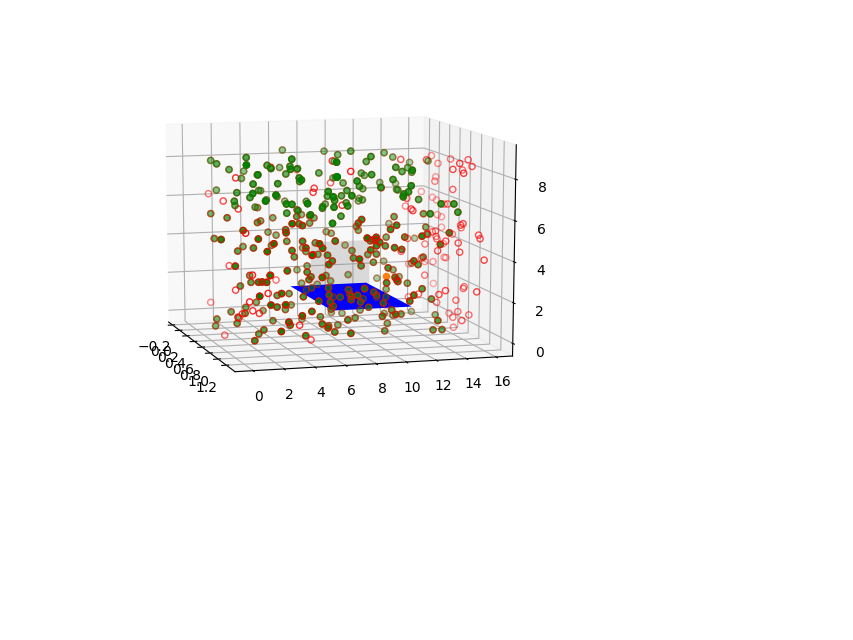

IndexError: list index out of range

In [24]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(num_row):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)
    
        # draw cyliders for the extending arms
        for rows in range(num_row):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(fruit_row_ed-3, fruit_row_tk+3)
        ax.set_zlim(fruit_row_bt-3, fruit_row_tp+3)
        
        ax.set_ylim(fruit_row_st-3, fruit_row_end+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
fig.show()



In [25]:
# need to print all the fruit that remains unpicked
miss  = 0
sched = 0 
pick  = 0

# prints all the fruit that has not been picked
for x in range(len(fruit.sortedFruit[1])):
    if fruit.sortedFruit[:,x][3] == 0: 
        miss += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 1:
        sched += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 2:
        pick += 1
        
# should plot the three different groups to see where they are
print("Total missed fruit:", miss)
print("Total scheduled, but not picked fruit:", sched)
print("Total picked fruit:", pick)

print("")
print("They add up to:", miss+sched+pick)
print("Total unpicked fruit:", miss+sched)

Total missed fruit: 20
Total scheduled, but not picked fruit: 38
Total picked fruit: 350

They add up to: 408
Total unpicked fruit: 58
